#HW4: Is Remy the best cook in town?

<img src="https://dl.dropboxusercontent.com/u/75194/remyego.png" width=600 height=400/>

Or, maybe, the question ought to be, could you combine the opinion of multiple Ego's into an electronic Egomaniac?

##Writing recommender systems

In this homework, you will create a recommendation system for **restaurants** using [collaborative filtering](http://en.wikipedia.org/wiki/Collaborative_filtering) (CF). We will use Nearest Neighbor, Regression, and Matrix Factorization, and combine them using a simple ensemble method.

The recommenders we write will not be particularly good or sophisticated, but we shall carry out the entire process someone who competed on the Netflix prize did, and on the way, we'll learn a lot about the gotchas and subtleties involved.

The general structure of a recommendation system is that there are users and there are items. Here, the users are folks who have critiqued restaurants, while the items are the restaurants themselves. Users express explicit or implicit preferences towards certain items. CF thus relies on users' past behavior.

The first part of any recommender system is to create baseline estimate of the ratings. Indeed, most of any rating can be usually explained by baseline estimates, and all other methods are an attempt (only sometimes successful, as we shall see) to improve these baselines. We shall create two baselines here: one based on estimating biases with sample averages, and the second one using regularized regression.

There are two primary approaches to CF: neighborhood and latent factor model. The former is concerned with computing the relationships between items or between users. In the latter approach you have a model of hidden factors through which users and items are transformed to the same space. For example, if you are rating movies we may transform items into genre factors, and users into their preference for a particular genre.

Factor models generally lead to more accurate recommenders. One of the reasons for this is the sparsity of the item-user matrix. Most users tend to rate barely one or two items. Latent factor models are more expressive, and fit fewer parameters. However, neighborhood models are more prevalent, as they have an intuitive aspect that appeals to users(if you liked this you will like that) and online(a new preference can be incorporated very quickly).

Most recommenders today combine neighborhood CF with latent model based CF with matrix factorization approaches to latent factor models. 

In this homework you will learn:

1. how to set up a sample based average baseline model
1. how to set up a collaborative filtering model, calculating a part of it using map-reduce methods
2. predict from the model using neighborhood based CF approaches
3. How to set up a baseline model using ridge regression 
4. How to set up a matrix factorization using alternating least squares, and how to predict from it
4. How to combine the results from both models into a "ensemble" model using stacked regression

In doing this homework you will be following the path that people who participated in the Netflix prize did. See https://datajobs.com/data-science-repo/Collaborative-Filtering-[Koren-and-Bell].pdf for advances in Collaborative Filtering brought about by the prize. Also see a very readable description of what went into the winning models [here](http://blog.echen.me/2011/10/24/winning-the-netflix-prize-a-summary/).

##This homework is due Thursday, November 5th 2015, at 11:59PM EST.

We'll grade the last commit you make before the homework deadline. We will be looking for the file `hw4.ipynb`.

**Start NOW. This is a long homework. Longer than HW2 and HW3.**

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

#Table of Contents
* [HW4: Is Remy the best cook in town?](#HW4:-Is-Remy-the-best-cook-in-town?)
	* [Writing recommender systems](#Writing-recommender-systems)
	* [This homework is due Thursday, November 5th 2015, at 11:59PM EST.](#This-homework-is-due-Thursday,-November-5th-2015,-at-11:59PM-EST.)
		* [User and Item based approaches](#User-and-Item-based-approaches)
	* [Q1 EDA and the Baseline Model](#Q1-EDA-and-the-Baseline-Model)
		* [Choosing a workable data frame](#Choosing-a-workable-data-frame)
			* [1.1 Visualize the sparsity of the data set](#1.1-Visualize-the-sparsity-of-the-data-set)
		* [Splitting into testing and training sets](#Splitting-into-testing-and-training-sets)
		* [The baseline model](#The-baseline-model)
			* [1.2 Calculate dictionaries of user and restaurant biases and plot histograms for them](#1.2-Calculate-dictionaries-of-user-and-restaurant-biases-and-plot-histograms-for-them)
		* [Making baseline predictions](#Making-baseline-predictions)
			* [1.3 Make the prediction from the `baseline` model](#1.3-Make-the-prediction-from-the-baseline-model)
	* [Q2 Collaborative Filtering using kNN](#Q2-Collaborative-Filtering-using-kNN)
		* [Setting up the Collaborative Filtering Model](#Setting-up-the-Collaborative-Filtering-Model)
			* [Global Recommender](#Global-Recommender)
			* [Local recommender](#Local-recommender)
		* [Common Support](#Common-Support)
		* [Calculating similarity](#Calculating-similarity)
			* [2.1 Write a function `pearson_sim` that calculates the pearson similarity](#2.1-Write-a-function-pearson_sim-that-calculates-the-pearson-similarity)
			* [Get Restaurant reviews](#Get-Restaurant-reviews)
		* [Making a database of similarities](#Making-a-database-of-similarities)
		* [Map reduce to populate database](#Map-reduce-to-populate-database)
			* [2.2 Write `mapper2`](#2.2-Write-mapper2)
			* [2.3 Write `reducer2`](#2.3-Write-reducer2)
			* [Checking our work](#Checking-our-work)
			* [Shrunk similarities](#Shrunk-similarities)
		* [Calculating Nearest Neighbors](#Calculating-Nearest-Neighbors)
			* [Similarity Distances](#Similarity-Distances)
			* [We write a function `knearest`](#We-write-a-function-knearest)
			* [2.4 Write a function to calculate the predicted rating for a user and restaurant](#2.4-Write-a-function-to-calculate-the-predicted-rating-for-a-user-and-restaurant)
		* [Predicting on a user's neighborhood](#Predicting-on-a-user's-neighborhood)
			* [An example](#An-example)
			* [2.5 Plot graphs for a 2x2 grid of `k` and `reg` and interpret your results](#2.5-Plot-graphs-for-a-2x2-grid-of-k-and-reg-and-interpret-your-results)
			* [2.6 Validate over `k` and `reg`](#2.6-Validate-over-k-and-reg)
			* [2.7 Use `mintup` to calculate and plot the results on the test set and compare the results with the baseline model](#2.7-Use-mintup-to-calculate-and-plot-the-results-on-the-test-set-and-compare-the-results-with-the-baseline-model)
		* [How to interpret these results?](#How-to-interpret-these-results?)
	* [Q3: The Baseline model with regularization](#Q3:-The-Baseline-model-with-regularization)
		* [Writing it as a Ridge Regression](#Writing-it-as-a-Ridge-Regression)
			* [3.1 Write a function to produce the design matrix](#3.1-Write-a-function-to-produce-the-design-matrix)
			* [3.2 Carry out the ridge regression!](#3.2-Carry-out-the-ridge-regression!)
		* [Prediction!](#Prediction!)
			* [3.3 Use this model to predict on the test set.](#3.3-Use-this-model-to-predict-on-the-test-set.)
			* [3.4 Compare the results from the simple baseline model to the regularized baseline model.](#3.4-Compare-the-results-from-the-simple-baseline-model-to-the-regularized-baseline-model.)
	* [Q4: Collaborative Filtering and The Latent Factor Model](#Q4:-Collaborative-Filtering-and-The-Latent-Factor-Model)
		* [Model Overview](#Model-Overview)
		* [Latent Factors by Matrix Factorization](#Latent-Factors-by-Matrix-Factorization)
			* [Constructing the design matrix](#Constructing-the-design-matrix)
			* [4.1 Write a function to compute `designq`.](#4.1-Write-a-function-to-compute-designq.)
		* [WARNING: this part might take some hours to a day to run!](#WARNING:-this-part-might-take-some-hours-to-a-day-to-run!)
			* [4.2 Make a prediction on the test set and plot your predictions compared to the basdeline model. Comment.](#4.2-Make-a-prediction-on-the-test-set-and-plot-your-predictions-compared-to-the-basdeline-model.-Comment.)
	* [Q5 Combining results into an ensemble](#Q5-Combining-results-into-an-ensemble)
		* [Adding a regularized baseline to kNN](#Adding-a-regularized-baseline-to-kNN)
			* [5.1 Find the best fit `knn_r model` on the validation set and test sets](#5.1-Find-the-best-fit-knn_r-model-on-the-validation-set-and-test-sets)
			* [5.2 Carry out an unregularized linear regression of the actual values against the three predictions](#5.2-Carry-out-an-unregularized-linear-regression-of-the-actual-values-against-the-three-predictions)
			* [5.3 Get the same models on the test set and use linear regression to calculate the predictions. Comment](#5.3-Get-the-same-models-on-the-test-set-and-use-linear-regression-to-calculate-the-predictions.-Comment)


### User and Item based approaches

Original approaches to neighborhood based CF used user-user models. By this we mean that rating estimates are made from recorded ratings of like minded users. However, since most users tend to rate very few items, this is usually a losing proposition for explicit-rating based recommenders. Thus, most neighborhood based systems such as Amazon these days rely on item-item approaches. In these methods, a rating is estimated by other ratings made by the user on "similar" or "nearby" items: we have a K-Nearest-Neighbors algorithm, in effect.

##Q1 EDA and the Baseline Model

The data file here that you read in is a database of reviews, one review per row from the Yelp web site.  The columns are:

* `user_id`: an opaque id for the reviewer
* `business_id`: an opaque id for the restaurant
* `date`: the date the review was made
* `review_id`: on opaque id for the review
* `stars`: the number of stars the user gave it
* `text`: the text of the review
* `business_avg`: the average rating this business got
* `business_review_count`: the number of reviews this business had
* `user_avg`: the average rating this user gave
* `user_review_count`: the number of reviews this user did.

Users rate restaurants on a scale of 1-5. Even though this rating is integer valued, for the purposes of this assignment we shall treat it as a real number.

We start with a 31MB in size data set and create a smaller one to start. The 31MB dataset is already too large for most of the computations in this notebook to complete within a few minutes, so we will need to pare it down.

In [2]:
bigdf=pd.read_csv("bigdf.csv")
bigdf.head()

,user_id,business_id,date,review_id,stars,usefulvotes_review,user_name,categories,biz_name,latitude,longitude,business_avg,business_review_count,user_avg,user_review_count
0,rLtl8ZkDX5vH5nAx9C3q5Q,9yKzy9PApeiPPOUJEtnvkg,2011-01-26 00:00:00,fWKvX83p0-ka4JS3dc6E5A,5,5,Jason,"[Breakfast & Brunch, Restaurants]",Morning Glory Cafe,33.390792,-112.012504,3.87156,109,3.796954,197
1,SBbftLzfYYKItOMFwOTIJg,9yKzy9PApeiPPOUJEtnvkg,2008-05-04 00:00:00,DASdFe-g0BgfN9J2tanStg,5,1,Jennifer,"[Breakfast & Brunch, Restaurants]",Morning Glory Cafe,33.390792,-112.012504,3.87156,109,3.473684,57
2,mlBC3pN9GXlUUfQi1qBBZA,9yKzy9PApeiPPOUJEtnvkg,2010-07-05 00:00:00,W8CX2h_hmODWmgSJVbMifw,2,1,Jennifer,"[Breakfast & Brunch, Restaurants]",Morning Glory Cafe,33.390792,-112.012504,3.87156,109,3.702381,84
3,0bNXP9quoJEgyVZu9ipGgQ,9yKzy9PApeiPPOUJEtnvkg,2012-10-10 00:00:00,nYVQiPGeiwr7g5BSX7WDJg,3,9,Aileen,"[Breakfast & Brunch, Restaurants]",Morning Glory Cafe,33.390792,-112.012504,3.87156,109,3.180077,261
4,T7J9ae0wTskrI_Bgwp-4cA,9yKzy9PApeiPPOUJEtnvkg,2009-12-17 00:00:00,grZNCXAgd-OH8daA28R-2A,3,1,Jasmine,"[Breakfast & Brunch, Restaurants]",Morning Glory Cafe,33.390792,-112.012504,3.87156,109,3.343284,201


The `recompute_frame` function below makes sure that a dataframe has the correct averages and counts for the ratings of businesses and users

In [3]:
def recompute_frame(ldf):
    """
    takes a dataframe ldf, makes a copy of it, and returns the copy
    with all averages and review counts recomputed
    this is used when a frame is subsetted.
    """
    ldfu=ldf.groupby('user_id')
    ldfb=ldf.groupby('business_id')
    user_avg=ldfu.stars.mean()
    user_review_count=ldfu.review_id.count()
    business_avg=ldfb.stars.mean()
    business_review_count=ldfb.review_id.count()
    nldf=ldf.copy()
    nldf.set_index(['business_id'], inplace=True)
    nldf['business_avg']=business_avg
    nldf['business_review_count']=business_review_count
    nldf.reset_index(inplace=True)
    nldf.set_index(['user_id'], inplace=True)
    nldf['user_avg']=user_avg
    nldf['user_review_count']=user_review_count
    nldf.reset_index(inplace=True)
    return nldf

In [4]:
bigdf=recompute_frame(bigdf)

### Choosing a workable data frame

The `compute_supports` function below computes the number of common users between two restaurants. This number is critical to understanding how similar restaurants are. With no users or just 1 user rating both restaurants in a pair, one cant really compare them. And the more users two restaurants have in common, the more we are likely to trust this number, which we shall call the **common support**. This similarity is important in neighborhood based models

In [5]:
def compute_supports(df):
    uuids=df.user_id.unique()
    rests = df.groupby('business_id').user_id.unique()
    bdict={}
    for e,v in zip(rests.index.values, rests.values):
        bdict[e] = np.array([item in v for item in uuids])
    restaurants=bdict.keys()
    supports=[]
    for i,rest1 in enumerate(restaurants):
        for j,rest2 in enumerate(restaurants):
            if  i < j:
                supmask = (bdict[rest1] & bdict[rest2])
                common_reviewers = np.sum(supmask)
                supports.append(common_reviewers)
    print "mean support",np.mean(supports), "median support", np.median(supports)
    return supports, bdict

The `make_smaller` function here is to take `bigdf` and make it smaller by having conditions on how many reviews a business must have, and how many reviews a user must have made.

The former condition, having two restaurants have much common support, is more likely if we choose restaurants in our data set that have many reviews.  However, if we choose users with many reviews, it is quite likely that we will miss the "long tail" of reviews which will make sure we have high common support. By "long tail", we here mean the many users who have rated 1-2 restaurants each, but whose ratings of these restaurants together help put together a reasonable (say, $\gt$ 10) total of ratings for those restaurants.

However, we cant choose too few reviews either. Two problems arise when we do this. Firstly, we want to split our data set into train, validate, and test parts. If we have users with too few reviews, we wont have enough data about the user to train on to make any good predictions, given that we must keep some of this user data aside in the test and validation sets. Secondly, if a user has too few reviews, when we look for the $k$ nearest neighbors of the item we are tring to predict on, there will be too many users with a totality of reviews less than $k$.

But the flip side of this is again, if we create a dataset with users with many reviews, we are creating a more biased sample. Most users review very little.

The way out of this conundrum is to create validation and test sets with users that have more reviews, so that have data left over. This skews our prediction accuracies towards more prolific users a bit (we take care not to skew it too much), but brings us the ability to have something to validate and test on.

You should remember that we are doing all this to make a simple small dataset for this homework. Real world datasets need to deal with even greater sparsiy and so on. As an example, see the README for the Netflix Dataset: http://www.cs.utexas.edu/users/downing/netflix/README .

In [6]:
def make_smaller(df, bizcount, usercount):
    smallidf1=df[(df.business_review_count > bizcount)]
    smallidf1=recompute_frame(smallidf1)
    smallidf2=smallidf1[(smallidf1.user_review_count > usercount)]
    smalldf=recompute_frame(smallidf2)
    return smalldf

In [7]:
smalldf=make_smaller(bigdf, 150, 5)
smalldf.to_csv("small.csv", index=False)
print "Number of Reviews",smalldf.shape[0]
print "Number of Users", smalldf.user_id.unique().shape[0]
print "Number of Businesses", smalldf.business_id.unique().shape[0]
s,d=compute_supports(smalldf)

Number of Reviews 18962
Number of Users 1532
Number of Businesses 172
mean support 11.564871481 median support 9.0


User review counts mean and median 12.3772845953 9.0


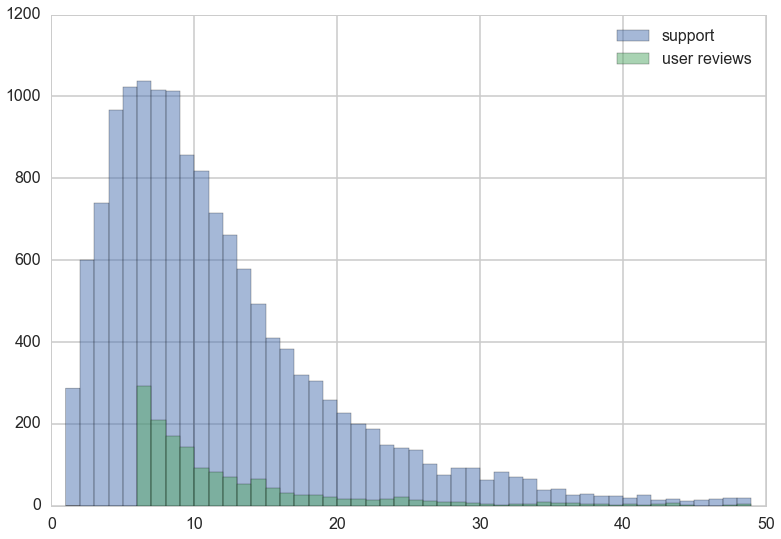

In [8]:
plt.hist(s, bins=np.arange(1,50,1), alpha=0.5, label="support");
c=smalldf.groupby('user_id').business_id.count()
print "User review counts mean and median",np.mean(c), np.median(c)
plt.hist(c, bins=np.arange(1,50,1), alpha=0.5, label="user reviews");
plt.legend();

Just in case a user has made a review twice, we drop it.

In [9]:
print smalldf.shape
smalldf=smalldf.drop_duplicates(['user_id','business_id'])
print smalldf.shape

(18962, 15)
(18962, 15)


#### 1.1 Visualize the sparsity of the data set 

Plot two histograms of the review count grouped by the user_id and business_id respectively. The first plot ought to be the number of reviews per user, and the second the number of reviews per restaurant. Describe what you see.

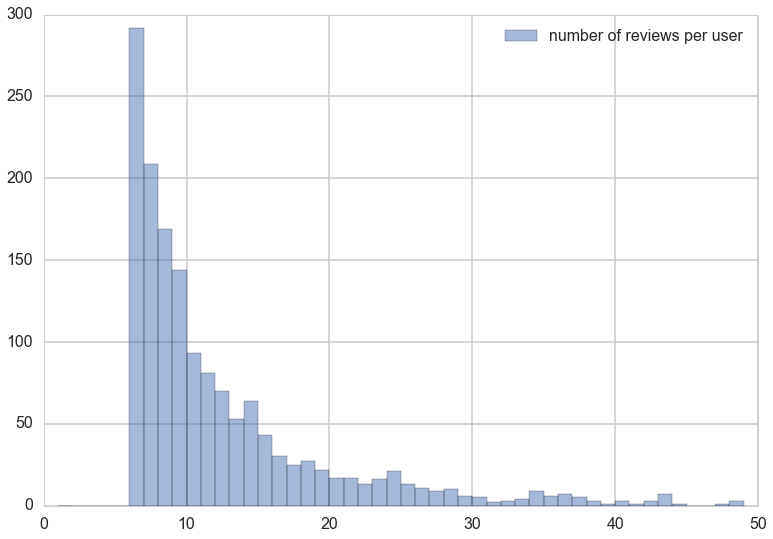

In [10]:
#your code here
c1=smalldf.groupby('user_id').user_review_count.count()
plt.hist(c1, bins=np.arange(1,50,1), alpha=0.5, label="number of reviews per user");
plt.legend();

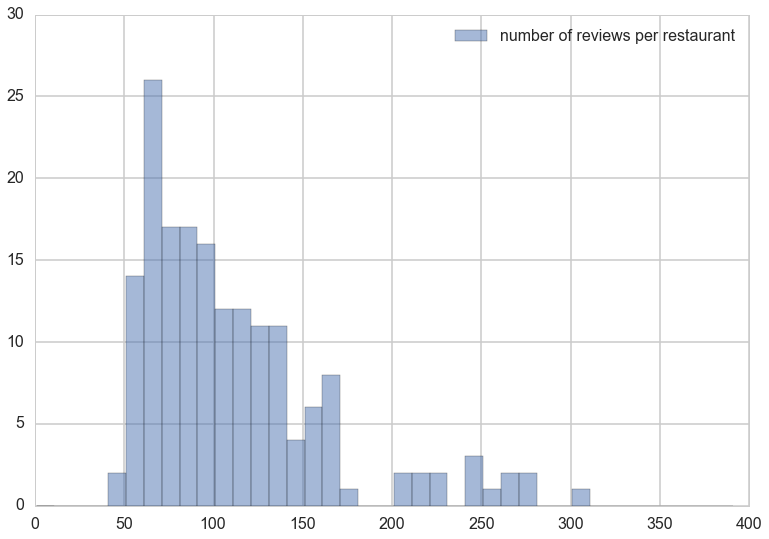

In [11]:
#your code here
#plt.hist(c2, bins=np.arange(40,90,1), alpha=0.5, label="number of reviews per restaurant");
c2=smalldf.groupby('business_id').business_review_count.count()
plt.hist(c2, bins=np.arange(1,400,10), alpha=0.5, label="number of reviews per restaurant");
plt.legend();

*your answer here*
The distribution for the number of reviews per user and the distribution for the number of reviews per restaurant are both right-skewed.  A vast concentration of users wrote less than 20 reviews, while a vast majority of the restaurants had less than 150 reviews.

### Splitting into testing and training sets

We're going to split our dataset into training, validation, and testing sets. To do this we first group our data by user id. The reason for doing this is that in each of these lists we create, we want each user to be represented. Otherwise, how would we test our predictions for that user? 

Then we choose 5 reviews per user, and put 3 in the validation and 2 in the testing set, as long as that user has rated more than 12 restaurants. All other reviews are left for the training set.

This implements the strategy we talked about above.

In [12]:
smalldf[smalldf.user_review_count > 12].shape

(10438, 15)

In [13]:
trainlist=[]
testlist=[]
validatelist=[]
take=5
for k, v in smalldf.groupby('user_id'):
    if np.mean(v.user_review_count) > 12:
        takenos=np.random.choice(range(take), size=take/2, replace=False)
        takelist=np.array([e in takenos for e in range(take)])
        validatelist.append(v[-take:][~takelist])#use those 
        testlist.append(v[-take:][takelist])#use the other 
        trainlist.append(v[:-take])
    else:
        trainlist.append(v)
traindf=pd.concat(trainlist)
validatedf=pd.concat(validatelist)
testdf=pd.concat(testlist)
print traindf.shape, validatedf.shape, testdf.shape

(16592, 15) (1422, 15) (948, 15)


To be on the safe side, we also test that any business from the validation and test sets was encountered in the training set. 

In [14]:
maskval=[e in set(validatedf.business_id).difference(set(traindf.business_id)) for e in validatedf.business_id] 
masktest=[e in set(testdf.business_id).difference(set(traindf.business_id)) for e in testdf.business_id] 
print np.sum(maskval), np.sum(masktest)

0 0


We recompute our sets' counts and averages, and use only some columns on the validation and test sets.

In [15]:
traindf=recompute_frame(traindf)
validatedf=recompute_frame(validatedf)
testdf=recompute_frame(testdf)
validatedf=validatedf[['user_id', 'business_id','stars', 'review_id']]
testdf=testdf[['user_id', 'business_id', 'stars', 'review_id']]
traindf.head()

,user_id,business_id,date,review_id,stars,usefulvotes_review,user_name,categories,biz_name,latitude,longitude,business_avg,business_review_count,user_avg,user_review_count
0,--65q1FpAL_UQtVZ2PTGew,eIxSLxzIlfExI6vgAbn2JA,2010-04-05 00:00:00,cr-8VthsH_j8yFTak1t7NQ,5,2,Nader,"[Burgers, Hot Dogs, American (New), Restaurants]",Lobbys Beef Burgers Dogs,33.394770,-111.908894,4.185714,70,4.111111,27
1,--65q1FpAL_UQtVZ2PTGew,-sC66z4SO3tR7nFCjfQwuQ,2010-04-04 00:00:00,Xhzo4VoHtjyTMJ8tt6TxMw,4,0,Nader,"[Mexican, Restaurants]",Gallo Blanco Cafe,33.491120,-112.079081,4.197581,248,4.111111,27
2,--65q1FpAL_UQtVZ2PTGew,bzDs0u8I-z231QVdIQWkrA,2010-07-22 00:00:00,lk6_3yIyphQafvZrtMC5tA,4,2,Nader,"[Mexican, Restaurants]",Los Reyes de la Torta,33.570813,-112.065737,4.142857,105,4.111111,27
3,--65q1FpAL_UQtVZ2PTGew,3n9mSKySEv3G03YjcU-YOQ,2010-04-04 00:00:00,_KpbnvLy6CBRLsbjvUffIw,5,0,Nader,"[Wine Bars, Bars, Restaurants, Nightlife, Ital...",Postino Central,33.512770,-112.074012,4.411765,204,4.111111,27
4,--65q1FpAL_UQtVZ2PTGew,IuAPYzf3NSyfyXYgT46YVA,2010-11-08 00:00:00,hiVOOp10wld7yIYE6dtrzw,5,8,Nader,"[Gastropubs, American (New), Restaurants]",FnB,33.497828,-111.927267,4.468354,79,4.111111,27


Lets save these files out so that we can use them if we lose our original files.

In [16]:
traindf.to_csv("tempdata/strain.csv", index=False, header=True, encoding="utf-8")
validatedf.to_csv("tempdata/svalidate.csv", index=False, header=True, encoding="utf-8")
testdf.to_csv("tempdata/stest.csv", index=False, header=True, encoding="utf-8")

In [17]:
testdf.head()

,user_id,business_id,stars,review_id
0,--65q1FpAL_UQtVZ2PTGew,AkOruz5CrCxUmXe1p_WoRg,4,BHVGulIMUyCV6gGEMkEe9A
1,--65q1FpAL_UQtVZ2PTGew,mqQwChPNN4o4DhAzaGntIA,5,9kSBXT6QBvwmSHN-zgk9Iw
2,-Dof9NwAoQwRM-GVPZk5zw,SDwYQ6eSu1htn8vHWv128g,5,BMNhB_wx5UnRnlW28mTUKA
3,-Dof9NwAoQwRM-GVPZk5zw,EKzMHI1tip8rC1-ZAy64yg,5,WdfHSfePS4gpMfexNjuA-g
4,-F32Vl8Rk4dwsmk0f2wRIw,h6jfMpTZpNduLG0wE2tbaw,3,4qWp7snroeoRk7FbPweTUQ


###The baseline model

To motivate our recommendation system, consider the following example. Let's pretend we are in Boston for a second. Lets say the average rating of restaurants here by all the users is 3.5. Sandrine's at Harvard square is better than an average restaurant, so it tends to be rated 0.5 stars above the average of all restaurants. However, you are a curmudgeon, who tends to rate 0.2 stars below the average. Then a baseline estimate for the recommendation for Sandrine's, for you, is 3.5+0.5-0.2=3.8.

These baseline estimates thus adjust the data by accounting for the systematic tendencies for some users who give higher ratings than others, and for some restaurants to receive higher ratings than others. We can write the baseline estimate $\hat Y_{um}^{baseline}$ for an unknown rating $Y_{um}$ for user $u$ and restaurant or business $m$ as:

$$ \hat Y_{um}^{baseline} = \hat \mu + \hat \theta_{u} + \hat \gamma_{m} $$

where the unknown parameters $\theta_{u}$ and $\gamma_{m}$ indicate the deviations, or biases, of user $u$ and item $m$, respectively, from some intercept parameter $\mu$. 

Notice that the $\theta_{u}$ and $\gamma_{m}$ are parameters which need to be fit. The simplest thing to start with is to replace them by their "mean" estimates from the data. Thus:

$$ \hat Y^{baseline}_{um} = \bar Y + (\bar Y_u - \bar Y) + (\bar Y_m - \bar Y)$$

where $\bar Y_u$ =  `user_avg`, the average of all a user $u$'s ratings and $\bar Y_m$ = `business_avg`, the average of all ratings for a restaurant $m$. $\bar Y$ is the average rating over all reviews.

The final two terms correspond to the user-specific and item-specific bias in ratings, that is, how their ratings tend to systematically diverge from the global average. This is the simplest possible way to predict a rating, based only on information about *this* user and *this* restaurant.

We first get the overall mean.

In [18]:
ybar = traindf.stars.mean()
ybar

3.9429845708775315

For book-keeping and ordering we create lists of unique `user_id`s and `business_id`s, and a mapping of these id's to integers which we will use later as indices into similarity databases and regression design matrices

In [19]:
uuids=traindf.user_id.unique()#unique-user-ids
uiids=traindf.business_id.unique()#unique-item-ids

In [20]:
uuidmap={v:k for k,v in enumerate(uuids)}#of length U
uiidmap={v:k for k,v in enumerate(uiids)}#of length M

Then we get the unique userids and restaurant-ids (item ids) and for each such user and item, compute the user's average rating or bias of all the restaurants he/she has rated, and the restaurant's (item's) average rating or bias over all the users who rated it.

#### 1.2 Calculate dictionaries of user and restaurant biases and plot histograms for them

Using the `uuids` and `uiids` create dictionaries `user_biases` and `item_biases` respectively. These have keys user ids and item ids respectively with values user biases and item biases respectively. Plot histograms of both the user bias and item bias. Plot the means and medians as well. Finally, also plot a bar-chart of all the ratings in the training set. Comment on the trends you see. 

In [21]:
#your code here
user_biases={}
for uuid in uuids:
    #get the user average
    useravg = traindf.loc[traindf['user_id'] == uuid].user_avg.iloc[0]
    #store the user bias value
    user_biases[uuid] = useravg-ybar

item_biases={}
for uiid in uiids:
    #get the item average
    itemavg = traindf.loc[traindf['business_id'] == uiid].business_avg.iloc[0]
    #store the item bias value
    item_biases[uiid] = itemavg-ybar


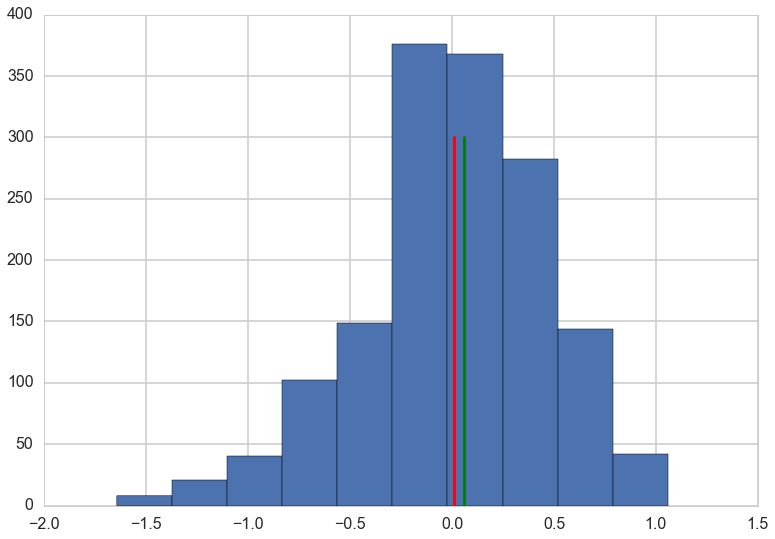

In [22]:
#your code here
#plt.hist(c2, bins=np.arange(1,400,10), alpha=0.5, label="number of reviews per user");
plt.hist(user_biases.values(), label="user biases");
plt.axvline(np.mean(user_biases.values()),ymax=0.75,color='red')
plt.axvline(np.median(user_biases.values()),ymax=0.75,color='green')

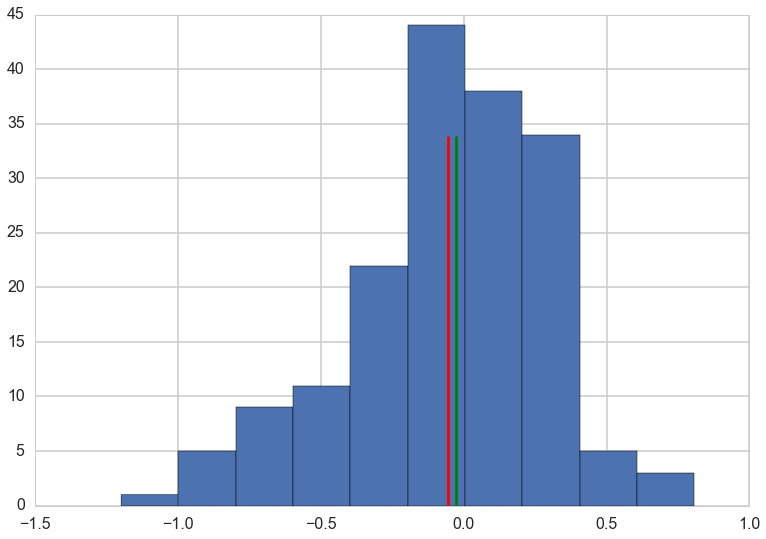

In [23]:
#your code here
plt.hist(item_biases.values(), label="item biases");
plt.axvline(np.mean(item_biases.values()),ymax=0.75,color='red')
plt.axvline(np.median(item_biases.values()),ymax=0.75,color='green')

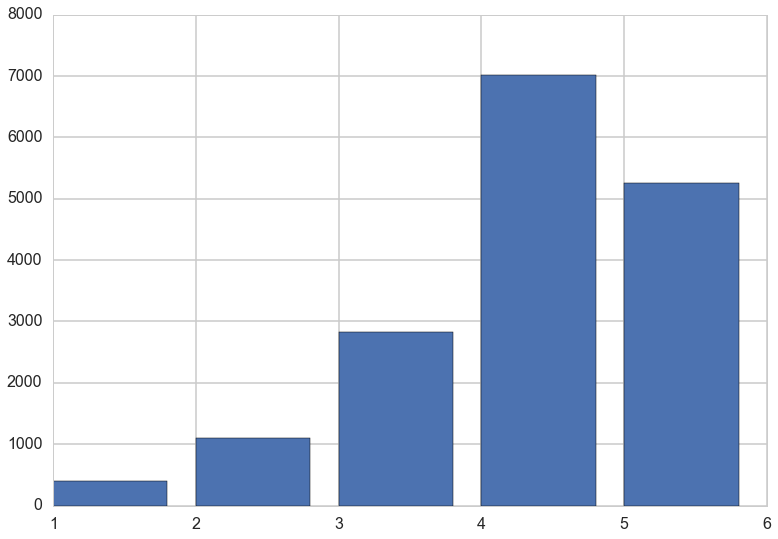

In [24]:
#your code here
plt.bar(traindf.groupby('stars').count().user_review_count.index,
        traindf.groupby('stars').count().user_review_count.values, 
        label="number of stars",width=0.8);

*your answer here*
Interestingly enough this time our data is actually slightly leftwardly skewed.  Users tended to, on average, have a postive bias (As evidenced by the positive mean and median), while restaurants, on average, tended to have a negative bias (as evidenced by the negative mean and median).

We save the mean and the biases into a dictionary for use later

In [25]:
train_avgs={'mean':ybar, 'users':user_biases, 'items':item_biases}

###Making baseline predictions

We'll create a dictionary `predictions` with keys the names of the models we use, and value the predictions on the test set. We'll also create a dictionary `predictions_valid` which saves the results of models on the validation set. This might seem a strange thing to do, but as we shall see later, this will come useful in ensembling

In [26]:
predictions={}
predictions_valid={}

####1.3 Make the prediction from the `baseline` model

Store the predictions on the test set `testdf` in `predictions["baseline"]`, and on the validation set in `predictions_valid` with the same key.

In [27]:
#your code here

#create list of relevant values for testdf and validatedf, respectively
pred_test = []; pred_validate = []

for row in testdf.index:
    u = testdf['user_id'][row] #get user info
    b = testdf['business_id'][row] #get biz info
    #get yhat
    pred_test.append(train_avgs['mean'] + train_avgs['users'][u] + train_avgs['items'][b])

for row in validatedf.index:
    u = validatedf['user_id'][row] #get user info
    b = validatedf['business_id'][row] #get biz info
    #get yhat
    pred_validate.append(train_avgs['mean'] + train_avgs['users'][u] + train_avgs['items'][b])

#store the values in the dataframes
predictions['baseline'] = pred_test
predictions_valid['baseline'] = pred_validate

How did we do?

We define a function to calculate the root-mean-square error between actual values and predictions. We could have used the corresponding function in `sklearn` as well.

In [28]:
def get_rmse(s, s_predict):
    diff = s - s_predict
    return np.sqrt(np.dot(diff,diff)/diff.shape[0])

We now write a `compare_results` function which plots the predicted star values against the actual ones. The x axis is the actual rating, so predicted results at any integer star value will be up and down the grid line at that value. We take the average of the ratings and plot a point there, and fill-inbetween one standard deviation on each side of this point. We also plot the 45 degree line for reference.

In [29]:
def compare_results(stars_actual, stars_predicted, ylow=1, yhigh=6, model="", predicteds=False, onsame=False, axis=False):
    """
    plot predicted results against actual results. Takes 2 arguments: a
    numpy array of actual ratings and a numpy array of predicted ratings
    scatterplots the predictions, a unit slope line, line segments joining the mean,
    and a filled in area of the standard deviations."
    """
    if onsame:
        ax=onsame
    elif axis:
        ax=axis
    else:
        fig=plt.figure()
        ax=plt.gca()
    df=pd.DataFrame(dict(actual=stars_actual, predicted=stars_predicted))
    xp=[]
    yp=[]
    for k,v in df.groupby('actual'):
        xp.append(k)
        yp.append(v.predicted.mean())        
    
    cl, = ax.plot(xp,yp, 's-', label="means for %s" % model)
    c=cl.get_color()

    sig=df.groupby('actual').predicted.std().values
    ax.fill_between(xp, yp - sig, yp + sig, 
                 color=c, alpha=0.2)
    if predicteds:
        ax.plot(df.actual, df.predicted, '.', color=c, alpha=0.1, label="predicted for %s" % model)

    if not onsame:
        ax.plot([1,5],[1,5], 'k', label="slope 1")
        ax.set_xlabel("actual")
        ax.set_ylabel("predicted")
        ax.set_ylim([ylow,yhigh])
        ax.set_xlim([0.9, 5.1])
    ax.legend(frameon=False, loc="upper left")
    rmse=get_rmse(stars_actual, stars_predicted)
    print "RMSE for %s" % model, rmse
    return ax,rmse

We see how our prediction works using the baseline model.

RMSE for baseline 0.949312108419


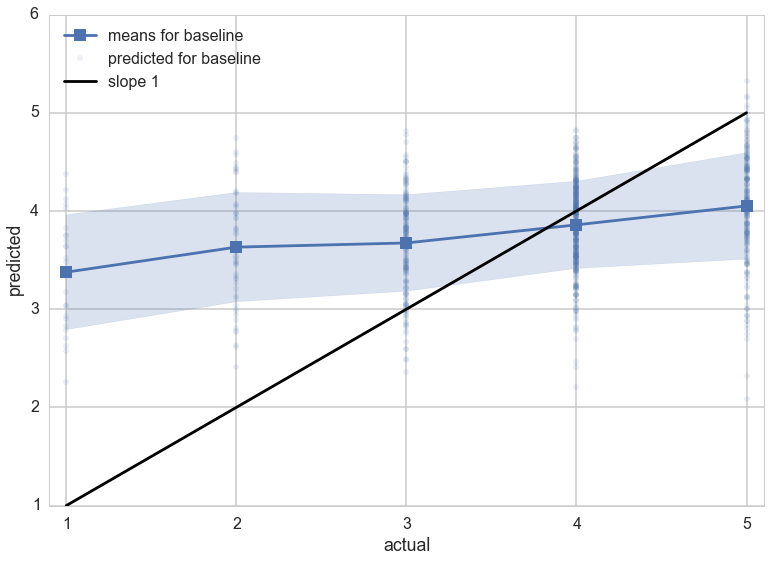

In [30]:
compare_results(testdf.stars,predictions['baseline'], model="baseline", predicteds=True);

How are we to interpret such diagrams?

Firstly, note that increasing bias in a model decreases the variation between the rating groups, resulting in a flatter blue curve. Here I am using the term bias in the sense of the bias-variance tradeoff. For example, the most biased model would be to leave out even the user and item "biases" (sorry for multiple uses of the term!) and just fit a flat average line, completely horizontal. Our prediction here is less biased than that.

The second thing to notice is that the precision as measured by the width of the grey region measures the variance WITHIN rating groups, not between them. 

##Q2 Collaborative Filtering using kNN

###Setting up the Collaborative Filtering Model

Can we do a better job of predicting the rating $Y_{um}$ user $u$ would give to restaurant $m$? According to the central dogma of CF, we ought to be able to use the responses of *similar* users regarding *similar* restaurants to get a better prediction. 

We can make an estimate of $Y_{um}$ as:

$$ \hat{Y_{um}} = \hat Y_{um}^{baseline}\, + \,\frac{\sum\limits_{j \in S^{k}(m)} s_{mj} ( Y_{uj} - \hat Y_{uj}^{baseline} )}{\sum\limits_{j \in S^{k}(m)} s_{mj} } $$

where $S^{k}(m)$ is the $k$ neighbor items of item $m$ based on some *pooling criterion*, for example, those items which have been rated by user $u$.


To do this, we compute a *similarity measure* $s_{mj}$ between the $m$th and $j$th items. This similarity might be measured via [cosine similarity](http://en.wikipedia.org/wiki/Cosine_similarity), [pearson co-efficient](http://en.wikipedia.org/wiki/Pearson_product-moment_correlation_coefficient) or using other distance based measures. Here we shall use the Pearson coefficient. This measures the tendency of users to rate items similarly. Since most ratings are unknown, it is computed on the "common user support" (`n_common`), which is the set of common raters of both items. This is why we spent some time earlier trying to craft a data set which was doable in reasonable time in the context of this homework but still having reasonable values of `n_common`.

####Global Recommender

**$S^{k}(m)$ depends on items only.**

Now we have a way to pool information between similar restaurants to try to predict a user's recommendation. But how do we choose the neighborhood to pool over? The simplest choice is to calculate the similarity between items using their entire common user support, and rank the nearest neighbors of an item by this similarity. We call this a "global" recommender because it assumes that every user perceives the similarity between restaurants in the same way. 
The global recommender does have the advantage of dealing with the possible sparsity of the user's rated items, but also the disadvantage of giving one answer for all users, without taking the user's preferences into account. This is a classic case of bias-variance tradeoff.

The above recommender also has a second problem: we have no way of telling how good our results are. The problem is this:

When I compute the global neighborhood of a restaurant, one of the restaurants in these `k` nearest neighbors might not have a rating from me in the training set, in the usual training-validation paradigm. So I cant compute that $Y_{uj}$ on the right hand side in the formula above. The best I could do is to use the average rating of restaurant in the training set. I can, of-course, still calculate the nearest neighbors and make recommendations based on the distances I calculate. 

We shall not do this recommender here. See HW4 in the 2013 cycle of cs109 for an example of such a recommender. But, you might see such a recommender in the wild: its then a good faith recommender, as it is very hard to validate such a recommender without playing games with averages.

####Local recommender

**$S^{k}(m) = S^{k}(m;u)$ depends on items and the user in question **

The aim is to get more fine-grained predictions about each user, and try to predict what _rating_ a user would give to a restaurant they have never tried before. To do this, we will try to personalize the information we use even further, and only pool information from restaurants that the user has rated.

This allows us to return to the original problem of prediction $Y_{um}$ for a restaurant $m$ that user $u$ has never rated before. Using our newly computed similarity metrics, we can modify our original baseline estimate by pulling in information from the user's neighborhood of the restaurant $m$, and predict $Y_{um}$ as:

$$ \hat{Y_{um}} = \hat Y^{baseline}_{um}\, + \,\frac{\sum\limits_{j \in S^{k}(m;u)} s_{mj} ( Y_{uj} - \hat Y^{baseline}_{uj} )}{\sum\limits_{j \in S^{k}(m;u)} s_{mj} } $$

where $s^{k}(m;u)$ is the $k$ neighbor items of item $m$ which have been rated by user $u$.

Now, this is not a particularly good assumption, especially in the situation where a restaurant is new (new item problem) or a user is new (cold start problem), or in the case when there are very few reviewers of a restaurant, or very few reviews by a user respectively. However, one must start somewhere!

Notice that in adding in the similarity term, we subtract the baseline estimate from the observed rating of the user's neighbor items.

###Common Support

Lets now make a histogram of the common user support (the number of common reviewers) of each pair of restaurants on the training set, and print the mean. We saw a function do this earlier when we created the smaller data set in `smalldf`. 

The common support is an important concept, as for each pair of restaurants, it is the number of people who reviewed both. It will be used to modify similarity between restaurants. If the common support is low, the similarity is less believable, and we would want to "regularize" it by some average estimate.

In this incarnation we create a two dimensional array `supports` which uses the `uiidmap`, and a Pandas Series `users_for_restaurants` with index the restaurant ids which will come useful later. We obtain the common reviewers as an intersection between two restaurants reviewers. We take care to fill the entire matrix including the diagonal. (This is the second implementation of a support finding routine you have seen: we use set intersections here; earlier we used boolean ANDs on a mask). You will write a third one, soon :-)

In [31]:
#for each restaurant get the unique userids who rated it
users_for_restaurants = traindf.groupby('business_id').user_id.unique()
restaurants=uiids
lres=len(restaurants)
supports=[[[] for i in range(lres)] for i in range(lres)]
supporthistlist=[]
for i,rest1 in enumerate(restaurants):
    for j,rest2 in enumerate(restaurants):
        if  i <= j:#its symmetric
            if rest1==rest2:
                common_reviewers=users_for_restaurants[rest1]
            else:
                common_reviewers = set(users_for_restaurants[rest1]).intersection(set(users_for_restaurants[rest2]))
                supporthistlist.append(len(common_reviewers))
            supports[i][j]=common_reviewers
            supports[j][i]=common_reviewers
print "Mean and Median support is:",np.mean(supporthistlist), np.median(supporthistlist)

Mean and Median support is: 8.49945600435 6.0


We see that the common support is a bit lower on the training set due to the loss of some ratings to the validation and test sets.

###Calculating similarity

Remember that even though each reviewer uses the same 5-star scale when rating restaurants, comparing two users by comparing their raw user ratings can be problematic. Consider a user whose average rating is 2. This is a curmudgeonly user. Consider another whose average rating is 4. This is a rather enthusiastic one. How should we compare a 3 rating by the curmudgeonly one to a 5 rating of the enthusiastic one? This is why we computed the baseline model in the last problem.

#### 2.1 Write a function `pearson_sim` that calculates the pearson similarity

We must subtract the average rating of the user from the actual rating of the restaurants in computing the similarity of two restaurants. This makes the ratings by the two users comparable. We do this in the function `pearson_sim` defined below.

If there is no common support (`n_common=0`), we have no basis for making a similarity estimate, and so we set the similarity to 0. In the case that the individual restaurant rating variance is 0, such as in the case where there is only one common reviewer (`n_common=1`), convert the `NaN` that the scipy `pearsonr` returns to`0.`.

In [32]:
from scipy.stats.stats import pearsonr
"""
Given a subframe or dictionary of restaurant 1 reviews and a subframe or dictionary of restaurant 2 reviews,
where the reviewers are those who have reviewed both restaurants, return 
the pearson correlation coefficient between the user average subtracted ratings.
The case for zero common reviewers is handled separately. If the correlation is
NaN if any of the individual variances are 0 (the n=1 case), return 0 instead
"""
#your code here
"""
    Step 1: Subtract average rating of user from actual rating of restaurant for restaurants 1 and 2
    Step 2: Find correlation in computing the similarity of two restaurants. 
    This makes the ratings by the two users comparable. We do this in the function pearson_sim defined below.
    
    n_common = 0 , set rho to 0
    when variance is 0 (e.g. n_common = 1) resulting in NaN, set rho to 0
    otherwise, use rho[0] from pearsonr
    
    Make sure to handle from both a dictionary with tuples as well as a straight dataframe
    """
def pearson_sim(rest1_reviews,rest2_reviews,n_common):
    #if n_common=0 or variance is 0 (aka n_common=1)
    if n_common==0 or n_common == 1:
        rho=0
    else:
        #difference btwn review & user average for restaurant 1
        diff1=rest1_reviews['stars']-rest1_reviews['user_avg']
        #difference btwn review & user average for restaurant 2
        diff2=rest2_reviews['stars']-rest2_reviews['user_avg']
        #calculate rho
        rho=pearsonr(diff1, diff2)[0]
    return rho
    
    

####Get Restaurant reviews

The function `get_restaurant_reviews` defined below takes a restaurant `business_id` and a set of users, and returns the reviews of that restaurant by those users. You will use this function in calculating a similarity function below. The set of users is all the users that rated a restaurant for the global recommender, and later, a restricted set for the local recommender.

In [33]:
def get_restaurant_reviews(restaurant_id, df, set_of_users):
    """
    given a resturant id and a set of reviewers, return the sub-dataframe of their
    reviews.
    """
    mask = (df.user_id.isin(set_of_users)) & (df.business_id==restaurant_id)
    reviews = df[mask]
    reviews = reviews[reviews.user_id.duplicated()==False]
    return reviews

### Making a database of similarities

We now move to calculating a global database of pairwise restaurant similarities.
We provide you here with a Class to make a database of the similarities for each pair of restaurants in the database. 

The class `Database` is initialized in its constructor `__init__` . A `class` is a construct which lets you store state in a program. Here we create a array for the database and fill it with zeros. 

The `set_supports` method is used to store the `supports` that we computed earlier.

The `get` method on the database can be used to retrieve the similarity for two business ids.

The general strategy for filling in this database is as follows:

1. For each of the two restaurants, we get the set of reviewers who have reviewed the restaurant and compute the intersection of these two sets. We also compute the number of common reviewers `n_common`.

2. We get the reviews for each restaurant as made by these common reviewers and get the star ratings and user averages. 

3. We calculate the similarity using `similarity_func`.

4. We return the similarity and `n_common` in a tuple `(sim, n_common)`. If the similarity is a `NaN`, set the similarity to 0.

In [34]:
class Database:
    "A class representing a database of similarities and common supports"
    
    def __init__(self, rindexmap, supports):
        "the constructor, takes a map of restaurant id's to integers"
        database={}
        self.rindexmap=rindexmap
        self.supports=supports
        l_keys=len(self.rindexmap.keys())
        self.database_sim=np.zeros([l_keys,l_keys])
        self.database_sup=np.zeros([l_keys, l_keys], dtype=np.int)

    def set_supports(self, supports):
        self.supports=supports
        
    def get(self, b1, b2):
        "returns a tuple of similarity,common_support given two business ids"
        sim=self.database_sim[self.rindexmap[b1]][self.rindexmap[b2]]
        nsup=self.database_sup[self.rindexmap[b1]][self.rindexmap[b2]]
        return (sim, nsup)

Lets create an instance of the `Database class`, using the `supports` and `uiidmap` we calculated when making the histogram of common supports and even earlier

In [35]:
db=Database(uiidmap, supports)

### Map reduce to populate database

We shall fill in the database using a map-reduce computation, which can, if implemented in mrjob or Spark, be scaled over multiple machines. Here we just wish to illustrate this process, and right our own implementation.

We display here, an outline of the implementation, so that the steps in the process can be followed:

```python
def map_reduce(tuples)
    mapped1=map(mapper1, tuples)
    combine1=combiner(mapped1)
    reduced1=reduce(lambda x,y: x + [reducer1(y)], combine1, [])
    mapped2=map(mapper2,reduced1)
    combine2=combiner_list(mapped22)
    output=reduce(lambda x,y: x + [reducer2(y)], combine2, [])
    return output
tuples=traindf.itertuples()
sims=map_reduce(tuples)
```

In [36]:
print traindf.columns
for row in traindf.head(2).itertuples():
    print row

Index([u'user_id', u'business_id', u'date', u'review_id', u'stars', u'usefulvotes_review', u'user_name', u'categories', u'biz_name', u'latitude', u'longitude', u'business_avg', u'business_review_count', u'user_avg', u'user_review_count'], dtype='object')
(0, '--65q1FpAL_UQtVZ2PTGew', 'eIxSLxzIlfExI6vgAbn2JA', '2010-04-05 00:00:00', 'cr-8VthsH_j8yFTak1t7NQ', 5, 2, 'Nader', '[Burgers, Hot Dogs, American (New), Restaurants]', 'Lobbys Beef Burgers Dogs', 33.394769899999993, -111.9088938, 4.1857142857142859, 70, 4.1111111111111107, 27)
(1, '--65q1FpAL_UQtVZ2PTGew', '-sC66z4SO3tR7nFCjfQwuQ', '2010-04-04 00:00:00', 'Xhzo4VoHtjyTMJ8tt6TxMw', 4, 0, 'Nader', '[Mexican, Restaurants]', 'Gallo Blanco Cafe', 33.491120000000002, -112.079081, 4.19758064516129, 248, 4.1111111111111107, 27)


Note the additional index at the beginning of the tuple.

**(1)** In `mapper1`, we first take *each* tuple in the form above from the dataframe, and apply the function using python's `map` to spit out a tuple of the form: `user_id, (business_id, stars, user_avg)`. `mapped1` is then a list of these tuples.

`mapped1=map(mapper1, tuples)`

In [37]:
def mapper1(row):
    return row[1], (row[2], row[5], row[14])

**(2)** Then, in `combiner` we do what a map reduce framework like hadoop does for us and "collect" all the tuples belonging to a given `user_id` to form a list `combine1` of the form `[(user_id, list of (business_id, stars, user_avg) ),...]`

`combine1=combiner(mapped1)`

In [38]:
def combiner(items):
    indict={}
    for key, value in items:
        if not indict.has_key(key):
            indict[key]=[]
        indict[key].append(value)
    return indict.items()

**(3)** Then, in `reducer1`, we use python's `reduce` function to reduce the list we made above into another list `reduced1`. This list is made by starting from the empty list `x=[]`. Then for each element `y` in `combine1`, we return a tuple of `user_id` with a list of tuples `[(business_id,(stars, user_avg)),...]`. Thus `reduced1` is a list of tuples `[(user_id, [(business_id,(stars, user_avg)),...]),...]`.

`reduced1=reduce(lambda x,y: x + [reducer1(y)], combine1, [])`

In [39]:
def reducer1(the_input):
    user_id, values = the_input
    ratings=[]
    for business_id,stars,user_avg in values:
        ratings.append((business_id,(stars, user_avg)))
    return user_id, ratings

**(4)** Its now your job to write the next mapper `mapper2`:

#### 2.2 Write `mapper2`

`mapped2=map(mapper2,reduced1)`

`mapper2` takes each element of the list `reduced1`, that is, something that looks like `(user_id, [(business_id,(stars, user_avg)),...])`. Use the function `combinations_with_replacement` from python's itertools module, and comes up with all possible 2-combinations of elements from the list `[(business_id,(stars, user_avg)),...]` (including those which repeat the element. You will notice that what this does is to output every combination of restaurant_id's that the user in question has reviewed.

So, ignoring the user_id key, take all combinations of business pairs and return a list whose items are tuples. Each tuple has 2 elements. The first element is a tuple of pair ids, and the second tuple is a tuple of pair rating information. The first tuple looks something like `(biz1_id, biz2_id)`, while the second one looks like `((stars1, user_avg1),(stars2, user_avg2))`. Make sure that if `biz1id > biz2id` lexicographically (which is a big way of saying alphabetically: using the alphabets imposes an ordering on restaurant ids), you reverse the order of both the tuples. What this does is that it ensures that the first business id is always smaller than or equal to the second one and thus we dont do extra work.

In [40]:
#your code here
from itertools import *
def mapper2(row):

    user_id, ratings = row
    mapper2_output = []
    for k, v in combinations_with_replacement(ratings, 2):
        #info about biz 1
        business1, business1r = k
        #info about biz 2
        business2, business2r = v
        #normal alphabetical order
        if business1 <= business2:
            out=(business1, business2), (business1r, business2r)
        #if out of order
        else:
            out=(business2, business1), (business2r, business1r)
        mapper2_output.append(out)
    return mapper2_output

#test_data = [('a',[('e',('f','g')),('b',('c','d')),('h',('i','j'))]),('l',[('m',('n','o')),('p',('q','r')),('s',('t','u'))])] 
#map(mapper2,test_data)

**(5)** We now run `mapper2` on the entire list `reduced1` and as before, run a combiner to *collect* all tuple-pairs with the first tuple as the key. This will now give us, for each business id pair, a list of `((stars1, user_avg1),(stars2, user_avg2))` tuples, and thus, a list of the common support of each business id pair, in the form `[(biztuple, list of ((stars1, user_avg1),(stars2, user_avg2))),...]` which we now store in `combine2`.

`combine2=combiner_list(mapped22)`


In [41]:
def combiner_list(itemslist):
    indict={}
    for items in itemslist:
        for key, value in items:
            if not indict.has_key(key):
                indict[key]=[]
            indict[key].append(value)
    return indict.items()

**(6)** Now we write the next reducer `reducer2`.

#### 2.3 Write `reducer2`

From `combiner_list`, for each business_id pair we get `common_ratings` which is a list of tuples with ratings by the same user for the two businesses in the form `[((stars1, user_avg1),(stars2, user_avg2)),..]`. Write a function `reducer2` that takes the output of `combiner_list` and uses these common ratings to return, for each restaurant pair, two tuples. The first tuple if a tuple of restaurant ids, while the second tuple is their pearson correlation and their common support. In other words, the last line of this reducer function ought to look something like `return (restaurant1_id, restaurant2_id), (rho, n_common)`.
Given that the output 

HINT: By converting these to dictionaries with values that are `np.array`s we can use the same `pearson_sim` similarity function we defined above.

In [42]:
#your code here
def reducer2(combiner_list):
    #tuple of biz id's
    biztup = combiner_list[0]
    #biz 1 id
    biz1_id = biztup[0]
    #biz 2 id
    biz2_id = biztup[1]
    #dict of info for res 1
    res1dict = {}
    #dict of info for res 2
    res2dict = {}
    #stars for res1
    res1slist=[]
    #user avg for res1
    res1ulist=[]
    #stars for res2
    res2slist=[]
    #user avg for res1
    res2ulist=[]
    #common support
    n_common = len(combiner_list[1])
    for res_ratings in combiner_list[1]:
        #rating & useravg for res1
        res1info = res_ratings[0]
        #rating & useravg for res2
        res2info = res_ratings[1]
        #rating = 1st element of res1 tuple
        res1slist.append(res1info[0])
        #user avg = 2nd element of res1 tuple
        res1ulist.append(res1info[1])
        #rating = 1st element of res2 tuple
        res2slist.append(res2info[0])
        #user avg = 2nd element of res2 tuple
        res2ulist.append(res2info[1])
    #storing values
    res1dict['stars']=pd.DataFrame(res1slist)
    res1dict['user_avg']=pd.DataFrame(res1ulist)
    res2dict['stars']=pd.DataFrame(res2slist)
    res2dict['user_avg']=pd.DataFrame(res2ulist)
    #calculating rho
    rho = pearson_sim(res1dict,res2dict,n_common)
    return (biz1_id,biz2_id),(rho,n_common)

Ok, so we create the `map_reduce` function for real and then run it!

In [43]:
def map_reduce(tuples):
    mapped1=map(mapper1, tuples)
    combine1=combiner(mapped1)
    reduced1=reduce(lambda x,y: x + [reducer1(y)], combine1, [])
    mapped2=map(mapper2,reduced1)
    combine2=combiner_list(mapped2)
    output=reduce(lambda x,y: x + [reducer2(y)], combine2, [])
    return output

In [44]:
tuples=traindf.itertuples()
sims=map_reduce(tuples)

We now populate our instance of the database class by passing the instance `db` to the function `populate_from_mr` below. It takes the output of the reducer, finds the integer indices corresponding to the business id's, and populates the slots in the database.

In [45]:
def populate_from_mr(db, df, mapredlist):
    for tpair,vpair in mapredlist:
        i1=db.rindexmap[tpair[0]]
        i2=db.rindexmap[tpair[1]]
        db.database_sim[i1][i2]=vpair[0]
        db.database_sup[i1][i2]=vpair[1]
        db.database_sim[i2][i1]=vpair[0]
        db.database_sup[i2][i1]=vpair[1]

In [46]:
populate_from_mr(db, traindf, sims)

#### Checking our work

To check your work, since this is your first exposure to map-reduce, we provide you functions to do this the usual way using numpy and pandas. We first create a second instance of the database.

In [47]:
db2=Database( uiidmap, supports)

The function `populate_by calculating` iterates over every possible pair of business_id's in the dataframe and populates the database with similarities and common supports. It takes as arguments a function the similarity function `similarity_func` like `pearson_sim` (`calculate_similarity` uses this to calculate the similarity).

We write the function `calculate_similarity` inside this class that is the workhorse method that we use to populate the database. This method operates between two restaurants and calculates a similarity for them, taking a dataframe and a similarity function `similarity_func`. 

In [48]:
def calculate_similarity(db, df, rest1, rest2, similarity_func):
    # find common reviewers
    common_reviewers = db.supports[db.rindexmap[rest1]][db.rindexmap[rest2]]
    n_common=len(common_reviewers)
    if rest1==rest2:
        return 1., n_common
    #get reviews
    rest1_reviews = get_restaurant_reviews(rest1, df, common_reviewers)
    rest2_reviews = get_restaurant_reviews(rest2, df, common_reviewers)
    sim=similarity_func(rest1_reviews, rest2_reviews, n_common)
    return sim, n_common

def populate_by_calculating(db, df, similarity_func):
    """
    a populator for every pair of businesses in df. takes similarity_func like
    pearson_sim as argument
    """
    items=db.rindexmap.items()
    for b1, i1 in items:
        for b2, i2 in items:
            if i1 <= i2:
                sim, nsup=calculate_similarity(db, df, b1, b2, similarity_func)
                db.database_sim[i1][i2]=sim
                db.database_sim[i2][i1]=sim
                db.database_sup[i1][i2]=nsup
                db.database_sup[i2][i1]=nsup

We run the `populate_by_calculating` function.

In [49]:
%%time
populate_by_calculating(db2, traindf, pearson_sim)

CPU times: user 1min 53s, sys: 936 ms, total: 1min 54s
Wall time: 1min 58s


Lets check it for a pair of results. Try some other tests. *These specific two may not be there in the training set so you will need to find your own test businesses.*

In [50]:
tpair=('FV0BkoGOd3Yu_eJnXY15ZA', 'O-Xa9GCFWI65YiBD5Jw_hA')
print db.get(tpair[0],tpair[1]),db2.get(tpair[0],tpair[1])

(-0.35570789088993721, 11) (-0.35570789088993721, 11)


In [51]:
print db.get(tpair[1],tpair[0]),db2.get(tpair[1],tpair[0])
print db.get(tpair[0],tpair[0]),db2.get(tpair[0],tpair[0])

(-0.35570789088993721, 11) (-0.35570789088993721, 11)
(1.0, 130) (1.0, 130)


#### Shrunk similarities

We are now going to find the k-nearest restaurants to a given restaurant based on the database of similarities that we calculated. But we have a problem.

Consider the two cases where there are two common reviewers, and where there are 40. In the former case, we might get a artificially high similarity based on the tastes of just this user, and thus we must reduce its importance in the nearest-neighbor calculation. In the latter case, we would get a much more unbiased estimator of the similarity of the two restaurants.

To control the effect of small common supports, we can **shrink** our pearson co-efficients. We shall do this by using the "regularization" parameter `reg`:

$$s_{mj} = \frac{N_{common}\, \rho_{mj}}{N_{common}+reg} $$

where $N_{common}$ (`n_common`) is the common reviewer support and $\rho_{ij}$ is the pearson co-relation coefficient.

Recall the notions of regularization introduced in class. We want to reduce the variance in our estimates, so we pull our estimates in toward a conservative point in a way that strongly corrals in estimates when there is very little data, but allows the data to speak when there is a lot. 

We define a function `shrunk_sim` which takes a `sim` and `n_common`, and shrinks the similarity down using the regularizer `reg`.

In [52]:
def shrunk_sim(sim, n_common, reg=3.):
    "takes a similarity and shrinks it down by using the regularizer"
    ssim=(n_common*sim)/(n_common+reg)
    return ssim

###Calculating Nearest Neighbors

Now we can move to writing a `knearest` function, which finds the `k` nearest neighbors of a given restaurant based on the shrunk similarities we calculate. Note that as defined here, the nearest neighbors are restricted to the restaurants a user has reviewed.

####Similarity Distances

The very idea of nearest neighbor should engender in you the idea of distances; and distances should not be negative.
Furthermore, you would not be able to use distances other than those implied by the correlation coefficient in the calculation of nearest neighbors (such as a Manhattan distance or Jacard similarity).

We can fix this for the case of pearson coefficient by just a simple rescaling to the 0-1 range!

$$ \rho \rightarrow \frac{1 - \rho}{2} $$.

Notice this quantity is always positive and between 0 and 1. Its 0 at full correlation, and 1 at full anticorrelation.

#### We write a function `knearest` 

This function returns a *k-length sorted list* of 3-tuples each corresponding to a restaurant, the k-nearest restaurants to one we ask for.

The tuple structure is `(business_id, shrunken distance, common support)` where the distance and common support are with respect to the restaurant whose neighbors we are finding, and the `business_id` is the id of the "nearby" restaurant found. The nearby restaurants are found from a supplied numpy array of restaurants `set_of_restaurants`. We use `itemgetter` from the `operator` module to do the sorting. 

In [53]:
"""
Function
--------
knearest

Parameters
----------
restaurant_id : string
    The id of the restaurant whose nearest neighbors we want
set_of_restaurants : array
    The set of restaurants from which we want to find the nearest neighbors
dbase : instance of Database class.
    A database of similarities, on which the get method can be used to get the similarity
  of two businesses. e.g. dbase.get(rid1,rid2)
k : int
    the number of nearest neighbors desired, default 7
reg: float
    the regularization.
    
  
Returns
--------
A sorted list
    of the top k similar restaurants. The list is a list of tuples
    (business_id, shrunken similarity, common support).
"""
from operator import itemgetter
def knearest(restaurant_id, set_of_restaurants, dbase, k=7, reg=3.):
    """
    Given a restaurant_id, dataframe, and database, get a sorted list of the
    k most similar restaurants from the set of restaurants.
    """
    similars=[]
    for other_rest_id in set_of_restaurants:
        if other_rest_id!=restaurant_id:
            sim, nc=dbase.get(restaurant_id, other_rest_id)
            ssim=shrunk_sim(sim, nc, reg=reg)
            simdist=(1. - ssim)/2.
            similars.append((other_rest_id, simdist, nc ))
    similars=sorted(similars, key=itemgetter(1))
    return similars[0:k]

We write a function `get_users_restaurants` to get the restaurants a user has rated, and what rating he or she gave them, in preparation for the prediction step.

In [54]:
def get_users_restaurants(df, user_id):
    dfuser=df[df.user_id==user_id]
    dfuserdedup=dfuser.drop_duplicates('business_id')
    return dict(zip(dfuserdedup.business_id.values, dfuserdedup.stars.values))

#### 2.4 Write a function to calculate the predicted rating for a user and restaurant

Now write a function that returns the predicted rating for a user and an item using the formula at the beginning of this problem. Include code to deal with the possibility that the sum of scores that goes in the denominator is 0: return an predicted rating of the baseline portion of the formula in that case. This function `rating` takes as arguments the `train_map` (for e.g., see `train_avg` from earlier which stores the baseline estimates of intercept (overall mean), user bias, and item bias), the database, the `set_of_restaurants`, the wanted `restaurant_id` and `user_id`, and `k` as well as the regularizer `reg`.

In [55]:
"""
Function
--------
rating

Parameters
----------
set_of_restaurants: Dictionary
    The dictionary of restaurant: star-rating pairs you want to make the prediction from.
    This would be the output of a function like get_users_restaurants
train_map: Dictionary
    A dictionary with keys mean, users and items which have estimates of
    overall average or intercept, user coefficients(averages), and
    item coefficients(averages) respectively
dbase : instance of Database class.
    A database of similarities, on which the get method can be used to get the similarity
  of two businessed. e.g. dbase.get(rid1,rid2)
restaurant_id : string
    The id of the restaurant whose nearest neighbors we want
user_id : string
    The id of the user, in whose reviewed restaurants we want to find the neighbors
k : int
    the number of nearest neighbors desired, default 7
reg: float
    the regularization.   
  
Returns
--------
A float
    which is the imputed rating that we predict that user_id will make for restaurant_id
    
Notes
--------
If the sum of scores is 0, return the baseline estimate of the ranking.
"""
#your code here
def rating(set_of_restaurants, train_map, dbase, restaurant_id, user_id, k=7, reg=3.):
    mu=train_map['mean'] #yhat
    restaurant_bias=train_map['items'][restaurant_id]
    user_bias=train_map['users'][user_id]
    yum_baseline=(user_bias + restaurant_bias + mu) #Y_um baseline
    nsum=0. #sum of sim*(Y_uj - Y_uj_baseline) (numerator)
    scoresum=0. #sum of sim (denominator)
    nears = knearest(restaurant_id,set_of_restaurants,dbase,k=k,reg=reg) #neighbors
    
    for r,sim,nc in nears:
        #sim,nc=dbase.get(r,restaurant_id)
        sim=1-sim #make 1 indicate full correlation
        yuj=set_of_restaurants[r] #Y_uj (rating of restaurant_j)
        yuj_avg=train_map['items'][r]
        yuj_baseline = (user_bias + yuj_avg + mu) #Y_uj baseline
        rminusb=(yuj - yuj_baseline)
        scoresum+=sim #denominator incrementing
        nsum+=sim*rminusb #numerator incrementing
    if scoresum > 0.:
        val =  nsum/scoresum + yum_baseline #final val
    else:
        val=yum_baseline #if the sum is fraction is 0
    return val


###Predicting on a user's neighborhood

####An example

Here is an example of how the prediction works:

In [56]:
trainuser=traindf.loc[0].user_id
testrest=testdf[testdf.user_id==trainuser].business_id.values[0]
print trainuser, testrest

--65q1FpAL_UQtVZ2PTGew AkOruz5CrCxUmXe1p_WoRg


In [57]:
def get_actual(df, userid, bizid):
    return df[(df.user_id==userid) & (df.business_id==bizid)]['stars'].values[0]

print "Actual", get_actual(testdf, trainuser, testrest)
print "Predicted",rating(get_users_restaurants(traindf, trainuser), train_avgs, db, testrest, trainuser, k=2, reg=3.)

Actual 4
Predicted 4.20377190046


We now write a function which uses the rating function you defined to make a set of predictions on the validation set. Note the default values for the `k` nearest neighbors and regularization `reg`. This function takes an input dataframe `indf`, typically the validation or test dataframe, and iterated over the ratings in this frame, using the `rating` function you wrote to make predictions. It returns a tuple `preds, actuals`. Each of the variables represents an array of ratings from `indf`, with `preds` being the predictions we made and `actuals` being the actual ratings.

In [58]:
def get_ratings_user_nbd(indf, traindf, train_map, db, k=2, reg=3.):
    zips=zip(indf.business_id, indf.user_id, indf.stars)
    preds=[]
    actuals=[]
    for (r,u,actual) in zips:
        pred=rating(get_users_restaurants(traindf, u),train_map, db, r,u, k, reg)
        preds.append(pred)
        actuals.append(actual)
    return np.array(preds), np.array(actuals)

To show the usage of this function, lets set $k$ and `reg` to 4 and use it on the training set itself so that we can see what overfitting looks like. Since the training data frame is large, this might take a minute to run.

RMSE for knn(user) on training k=4, reg=4 0.762676498615


(<matplotlib.axes._subplots.AxesSubplot at 0x10d026610>, 0.76267649861526987)

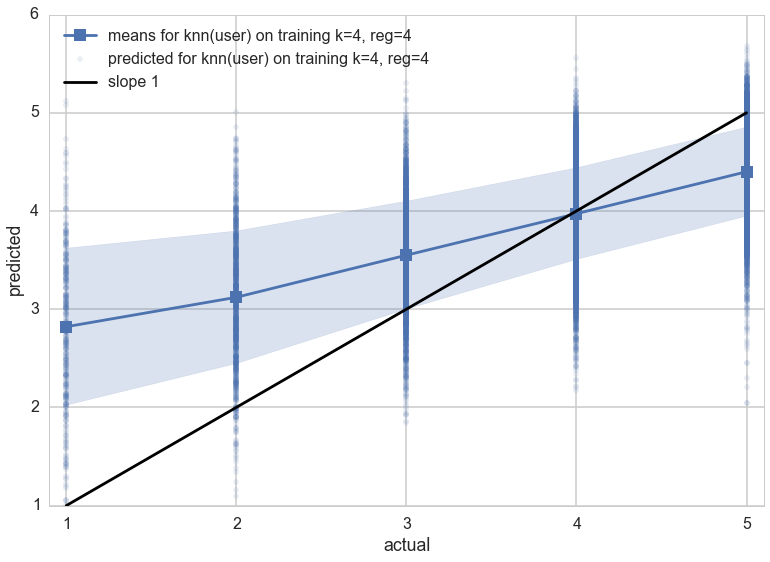

In [59]:
pt, at = get_ratings_user_nbd(traindf, traindf, train_avgs, db, k=4, reg=4.)
compare_results(at,pt, model="knn(user) on training k=4, reg=4", predicteds=True)

Note the really low RMSE.

#### 2.5 Plot graphs for a 2x2 grid of `k` and `reg` and interpret your results

Run four different models, for the combinations of parameters from `k=[2,15]` and `reg=[1.,15.]`. For each model, use `compare_results` to plot a graph of the results. Use the `axis` keyword argument of `compare_results` to plot these on a 2x2 grid. Interpret your results from both the rmse of the models and the graphs.

RMSE for knn(user) on training k=2, reg=1.0 0.790020531973
RMSE for knn(user) on training k=2, reg=15.0 0.792665650785
RMSE for knn(user) on training k=15, reg=1.0 0.827636835503
RMSE for knn(user) on training k=15, reg=15.0 0.86438026812


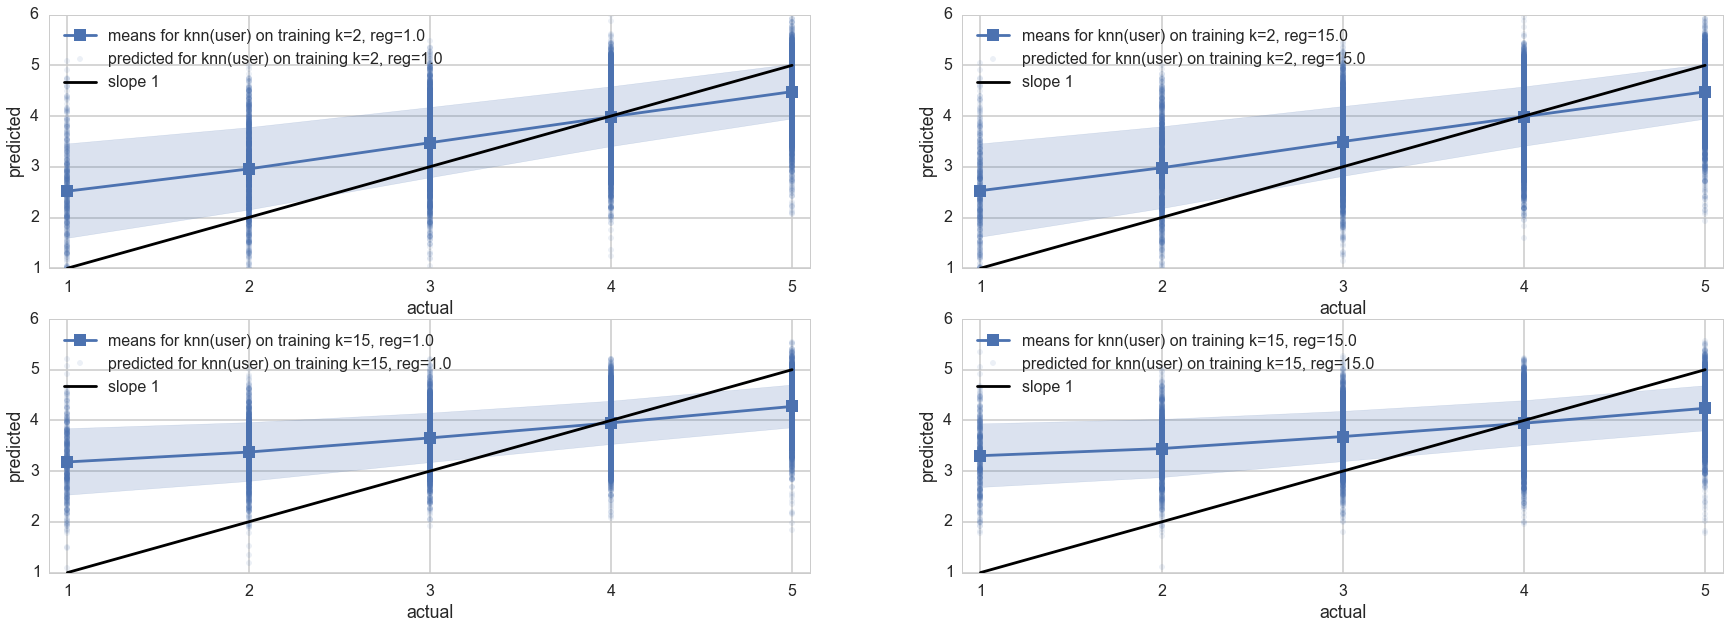

In [60]:
#your code here
#compare_results(stars_actual, stars_predicted, ylow=1, yhigh=6, model="", predicteds=False, onsame=False, axis=False):

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(30, 10))
#list of all pairs of k & reg
k_reg=[(2,1.),(2,15.),(15,1.),(15,15.)]
#counter to iterate through k-reg pairs
i=0
for ax in axes.ravel():
    #k is the first element of a k_reg tuple, and reg is the second element
    pt, at = get_ratings_user_nbd(traindf, traindf, train_avgs, db, k=k_reg[i][0], reg=k_reg[i][1])
    compare_results(at,pt, model="knn(user) on training k=%d" %k_reg[i][0] + ", reg=%0.1f" %k_reg[i][1], predicteds=True,axis=ax)
    i+=1

*your answer here*
From our results, it is obvious that increasing k or reg increases the RMSE as well.  We also see that increasing the k value from 2 to 15 causes a greater increase in RMSE than does increasing the reg value from 1 to 15.  This suggests that k plays a more significant role in influencing RMSE than does reg.

####2.6 Validate over `k` and `reg`

Now use this function defined in a Validation loop over different values of `k` between 1 and 100 and `reg` between 1 and 100. (Note: this is validation, not cross-validation). The validation loop will take a few minutes to run. Start with a coarse loop, but then fine grain it down to be within 5 on both parameters. Store in a dictionary `rmsedict`, keyed by the tuple `(k, reg)` the values of the root mean square error between the predictions and the actual values.

Depending on how many points you have on your gris, this might take a few minutes to run.

In [61]:
#your code here
rmsedict={}
#iterate through k and reg to find min value of mintup
for k in range(27,31,1):
    for reg in range(138,142,1):
        pt, at = get_ratings_user_nbd(validatedf, traindf, train_avgs, db, k=k, reg=reg)
        rmse=get_rmse(at, pt)
        #store k,reg as key and rmse as value
        rmsedict[(k,reg)]=rmse

Note the general flatness of the minimization surface in the parameter space.

We now get the values of the `k` and `reg` which minimize the root mean square error.

In [62]:
mintup=min(rmsedict, key=rmsedict.get)
mintup

(29, 140)

####2.7 Use `mintup` to calculate and plot the results on the test set and compare the results with the baseline model

Make predictions on the test and validation set. Store these in `predictions['knn']` and `predictions_valid['knn']` respectively. Plot the results on the test set and explain them. Compare the results against the  baseline model. Explain your results and how you think it will change with test and validation sets having reviews of restaurants with more support and users with more rankings.

RMSE for knn 0.948713296073
RMSE for baseline 0.949312108419


(<matplotlib.axes._subplots.AxesSubplot at 0x10e8a3d90>, 0.9493121084194851)

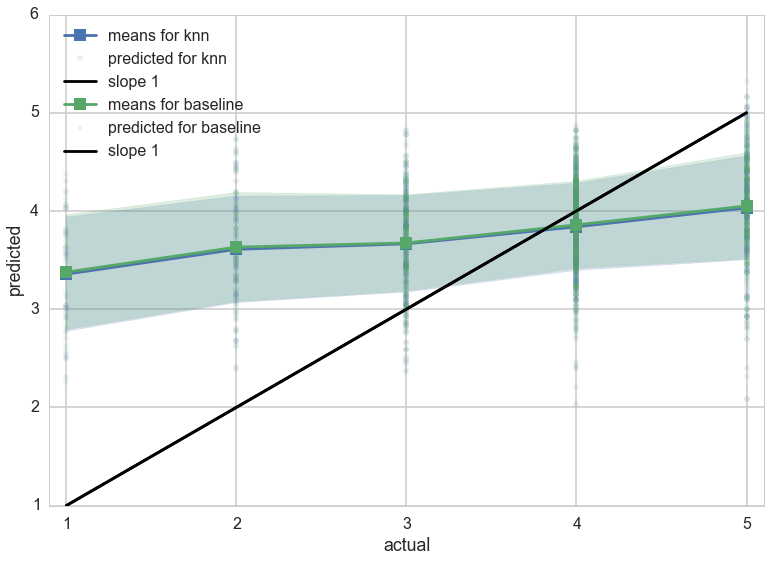

In [63]:
#your code here
#test predictions
predictions['knn'], a_test = get_ratings_user_nbd(testdf, traindf, train_avgs, db, k=mintup[0], reg=mintup[1])
#validation set predictions
predictions_valid['knn'], a_values = get_ratings_user_nbd(validatedf, traindf, train_avgs, db, k=mintup[0], reg=mintup[1])

#real world scenarios
ax=compare_results(a_test,predictions['knn'], model="knn", predicteds=True)
compare_results(testdf.stars,predictions['baseline'], model="baseline", predicteds=True,axis=ax[0])



*your answer here*
Although the graphs appear nearly identical, from the RMSE values we can see that the knn does slightly better than the baseline.  If we have more users we will have more variance, so there is a need for a higher regularization penalty (i.e. the value of reg).

###How to interpret these results?

In other words, how would you tell a user where to go eat?


In [64]:
randomuser=np.random.choice(uuids)
randomrest=np.random.choice(uiids)

set_of_restaurants = get_users_restaurants(traindf, randomuser)
tops=knearest(randomrest, set_of_restaurants, db, k=mintup[0], reg=mintup[1])
print "For restaurant",randomrest, " and user", randomuser, ", top matches are:"
for i, (biz_id, sim, nc) in enumerate(tops):
    print i,biz_id, "| Sim", sim, "| Support",nc,"| Actual", get_actual(traindf, randomuser, biz_id)

For restaurant FURgKkRFtMK5yKbjYZVVwA  and user uzWTAgkONAZd5NrfP9XXlQ , top matches are:
0 jJhNOhuGpIsJX5SEUFFWYQ | Sim 0.481957864275 | Support 6 | Actual 5
1 QnAzW6KMSciUcuJ20oI3Bw | Sim 0.494343659326 | Support 12 | Actual 4
2 SDwYQ6eSu1htn8vHWv128g | Sim 0.495654133494 | Support 32 | Actual 4
3 O-Xa9GCFWI65YiBD5Jw_hA | Sim 0.499419674308 | Support 11 | Actual 5
4 JokKtdXU7zXHcr20Lrk29A | Sim 0.50024521843 | Support 27 | Actual 5
5 4AKcmN--0hbF0kX9pg8scg | Sim 0.508758263548 | Support 3 | Actual 4
6 6oRAC4uyJCsJl1X0WZpVSA | Sim 0.52405614575 | Support 13 | Actual 5


One can also find the top recommendations for a user, for example. See 2013 homework for this.

## Q3: The Baseline model with regularization

The model we used in the last section was:

$$ \hat Y_{um}^{baseline} = \hat \mu + \hat \theta_{u} + \hat \gamma_{m} $$

where we estimated $\hat \theta_{u}$ as $\bar Y_u - \bar Y$ and $\hat \gamma_{m}$ as $\bar Y_m - \bar Y$.

###Writing it as a Ridge Regression

In this section we'll get more sophisticated and estimate these quantities as regularized regressions.

Look at the formula above. Notice that there is a constant term, $\hat \mu$, which looks like an intercept, and $N_{user}=U$ plus $N_{item}=M$ terms that dont exactly look like coefficients of a regression.

There are two key observations to be made which help us cast this problem as a regression. The first one is that we can flatten the non-zero elements of the recommendation matrix $ \hat Y_{um}^{baseline}$ into a column vector: 

![representation](representation.png)
The second key observation to make to recast the above equation into the following form:

$$ Y_{um}^{baseline} =  \mu + \bar \theta \cdot I_{u} +  \bar \gamma \cdot I_{m} $$

where $I_{u}$ and $I_{m}$ are indicator variables for the uth user and mth item that go into the feature matrix. Here $\bar \theta$ means the vector of all thetas, ie a vector of all the coefficients for users who have made ratings in our training set. Similarly $\bar \gamma$ is a vector of coefficients for all the items for which ratings have been made in our training set. In our previous model these coefficients were simply the sample means we used.

The indicator $I_{u}$ is a feature vector that takes on value 1 if it is user $u$ and 0 otherwise. We stack this horizontally with the indicator for item $m$ rated to create a row of the feature matrix. In other words, the row of our feature matrix for the regression for  $Y_{um}^{baseline} $ looks like

`1 (intercept),0(user 1),0(user 2),..,1(user u),..0(user N_users),0(item 1),0(item 2),..,1(item m),..,0(item N_items)`

This can be seen in the diagram below.
The left hand red column vector is the response, or the flattened-to-vector recommendation matrix. Note that now we are flattening only the known responses, and among then, even, only those on the training set. The right hand side has the intercept term (which used to be the baseline mean) plus the feature matrix multiplied by the co-efficients vector.  

And each row of this matrix consists of the horizontally stacked Indicator row vectors.  For example, if we are talking about the user with index 3 and item with index (ie, for $Y^{baseline}_{35}$), the first indicator vector has a 1 at the third (index 2) position and the second indicator has a 1 at the 5th (index 4) position.Then we put these side by side to create the entire row, moving on to do the same thing for the entire next row.

![expanding](expanding.png)

Now we are in business and can do a simple regression. 


BUT.

Notice that we have $U + M + 1$ coefficients to fit. Thats a lot. And in a problem that is very sparse..most of the actual observations of rating of a restaurant by a user simply dont exist. Users rate only a few restaurants each. All of this should remind you of the dreaded word of Machine Learning: Overfitting.

But we know how to deal with overfitting. We use Regularization. 

Thus we modify our model to:

$$  Y_{um}^{baseline} =  \mu +  \bar \theta \cdot I_{u} +  \bar \gamma \cdot I_{m} $$

such that we minimize:

$$\sum_{u,m} \left( Y_{um} -  \mu - \bar \theta \cdot I_{u} -  \bar \gamma \cdot I_{m} \right)^2 + \alpha \left( \theta_{u}^2 + \gamma_{m}^2 \right)$$

Now, this is exactly the form of a ridge regression on the feature matrix with horizontally stacked indicator vectors!

So let us set up the feature matrix (also called design matrix) for a ridge regression. In `sklearn` we dont need to model the intercept in the design matrix so the size of the design matrix is the number of samples in the training set times the sum of unique users and unique items.

In [65]:
from sklearn.linear_model import Ridge
features=np.concatenate([uuids,uiids])
features.shape

(1704,)

To construct the matrix, we take our dataframe, and set up a matrix of size $n_{samples} \times n_{features}$ and fill it with zero. We also set up the response $Y_{um}$. We then put a 1 in the design matrix for the $u$ and $m$ corresponding to the specific rating (thus two 1's in each sample row, all others 0's).

#### 3.1 Write a function to produce the design matrix

Write a function `getmats` which takes an input dataframe `indf` and outputs a tuple `designmatrix, ratings`. The `ratings` are the ratings from the `stars` column of the dataframe, in the order they were present in the dataframe. The design matrix is as described above, keeping this order in mind. HINT: using the `uiids` and `uuids` lists or the corresponding maps may be useful here.

In [66]:
#your code here
def getmats(indf):
    #access stars by locating the appropriate column
    ratings = indf['stars']
    #create empty matrix the size of the dataframe x number of columns
    designmatrix = np.zeros(shape=(len(indf),len(features)))
    #iterate through matrix
    for row in indf.index:
        user_id_ind = uuidmap[indf['user_id'][row]]
        item_id_ind = uiidmap[indf['business_id'][row]]
        #appropriately adjust values from 0 to 1
        designmatrix[row][user_id_ind] = 1
        designmatrix[row][item_id_ind] = 1
    return designmatrix,ratings

#### 3.2 Carry out the ridge regression!

Now we get the design matrix for the training and validation sets. 

In [67]:
designm, ratings = getmats(traindf)
validatedm, validaterats = getmats(validatedf)

Set up a bunch of $\alpha$s `[0.01, 0.1, 10, 100, 1000]` for our ridge regression, and carry it out. Notice that we are doing just one validation set here, rather than cross-validation, in the interests of saving on running time in this homework problem. (The Learning a Model lab might help you in your code here). 

Save in a dictionary `vdict`(validation-dict) keyed by the values of $\alpha$ above the root-mean-square-error(rmse) on the predictions, and in dictionary `rdict`(regression-dict) with the same keys the sklearn ridge regression instances for each $\alpha$.

In [68]:
#your code here
#list of alpha values
alphas = [0.01,0.1,10,100,1000]
#dictionary for ridges
rdict={}
#dictionary for ventures
vdict={}
for alpha in alphas:
    r_inst = Ridge(alpha=alpha)
    rdict[alpha] = r_inst.fit(designm,ratings)
    #predict volume data
    v_inst = r_inst.predict(validatedm)
    vdict[alpha] = get_rmse(validaterats,v_inst)
    

Lets find the $\alpha$ that minimizes the rmse's in vdict, and save in `regr` the corresponding regression

In [69]:
minerroralpha=min(vdict, key=vdict.get)
print minerroralpha
regr=rdict[minerroralpha] 

10


And see our intercept and how it compares to $\bar Y$.

In [70]:
regr.intercept_, ybar

(3.8752636509593383, 3.9429845708775315)

We save our intercept and coefficients into a training dictionary similar to the `train_avg` we saved earlier.

In [71]:
meancept=regr.intercept_
fitratmap_u={k:regr.coef_[i] for i,k in enumerate(uuids)}
fitratmap_i={k:regr.coef_[i+len(uuids)] for i,k in enumerate(uiids)}

In [72]:
train_fits={'mean':meancept, 'users':fitratmap_u, 'items':fitratmap_i}

###Prediction!

#### 3.3 Use this model to predict on the test set.

We set up the test design matrix and get the test ratings:

In [73]:
testdm, testrats = getmats(testdf)

Predict the ratings on the test set and store the results in `predictions['baseline_r']`. Use these to make a diagram of our results using the `compare_results` function we defined and used earlier. Also predict the ratings on the validation set and save in `predictions_valid['baseline_r']`

In [74]:
#your code here
#save baseline_r predictions for the tests
predictions['baseline_r'] = rdict[minerroralpha].predict(testdm)
#save baseline_r predictions for the tests
predictions_valid['baseline_r'] = rdict[minerroralpha].predict(validatedm)

#### 3.4 Compare the results from the simple baseline model to the regularized baseline model. 

Plot both of them on the same graph using `compare_results`. HINT: use the `onsame` parameter in that function. Explain the results, both in terms of the width of the 1-standard deviation bands, and how the predictions are different from the 45 degree line.

RMSE for regularized baseline 0.918452579545
RMSE for baseline 0.949312108419


(<matplotlib.axes._subplots.AxesSubplot at 0x10ab91f10>, 0.9493121084194851)

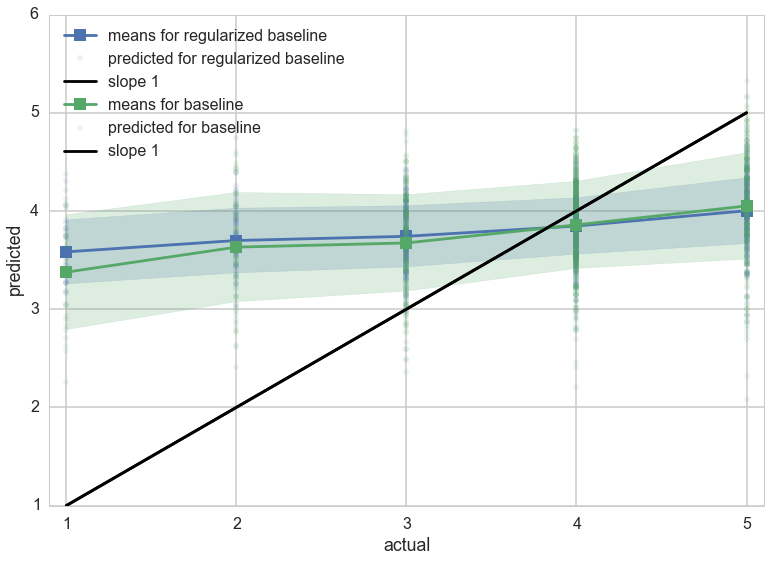

In [75]:
#your code here
#plotting baseline_r vs baseline
ax=compare_results(testrats,predictions['baseline_r'], model="regularized baseline", predicteds=True)
compare_results(testrats,predictions['baseline'], model="baseline", predicteds=True,axis=ax[0])

*your answer here*

The regularized baseline performs better than the normal baseline, as evidenced by the lower RMSE value.  The bands are much smaller, as evidenced by the smaller fill for the regularized baseline when compared to the normal baseline.

##Q4: Collaborative Filtering and The Latent Factor Model

### Model Overview

The central dogma in constructing a recommendation system using collaborative filtering is that *similar users will rate similar restaurants similarly*. Earlier we explicitly encoded this idea by using a similarity function to identify similar restaurants. We also assumed that either all users were the same (the global, maximal pooling, approach that we didnt do in this homework) or that only the current user was similar enough to make a recommendation (the user-specific approach that we did). In this section, we will use a model that allows us to identify both similar users and similar restaurants as a function of **latent factors**.

We can think of latent factors as properties of restaurants (e.g., spiciness of food or price) that users have a positive or negative preference for. We do not observe these factors or the users' preferences directly, but we assume that they affect how users tend to rate restaurants. For example, if a restaurant serves a lot of spicy food and a user dislikes spicy food, then the restaurant would have a high "spiciness" factor, and the user would have a strongly negative preference, resulting in a prediction of a low rating. Note that if users have similar preferences, then according to the model, they will behave similarly, and likewise, if restaurants have similar latent factors, they will be rated similarly by similar users. Latent factors thus give us an intuitive way to specify a generative model the obeys the central dogma, while retaining a certain explanatory globality, rather than simply a notion that one user is like another.

One issue that comes up with latent factor models is determining how many latent factors to include. There may be a number of different unmeasured properties that affect ratings in different ways -- for example, in addition to the spiciness factor above, there may also be a price factor that affects how users rate a restaurant. We can deal with the problem of choosing the number of latent factors to include in the same way we deal with choosing $K$ in a $K$-nearest neighbors problem.

###Latent Factors by Matrix Factorization

In HW4 for cs109 2013, a latent factor model was implemented using the MCMC technique Gibbs Sampling (if you take AM207 you will learn much more about this). Here we shall use another technique that builds on our regularized baseline model. This technique is called matrix factorization.

As you probably know by now, the usual method to do matrix factorization is the Singular Value Decomposition, or the SVD. However, conventional SVD is undefined when there are missing values in the matrix..in our case, the user-item matrix which has many, many missing values. 

So, how do we deal with this?

Let $r_{um}$ denote the "residual" rating of user $u$ for item $m$. By residual rating we mean whats left over after fitting the baseline, so:

$$r_{um} = Y_{um} - Y^{baseline}_{um}$$.

Let us associate with each item $m$ a vector $\bar q_{m}$ of length $L$, where L is the number of latent factors in the model. Similarly, lets associate with each user a vector $\bar p_{u}$ of length $L$. $\bar q_{m}$, either negative or positive, measures the extent to which an item(restaurant) possesses the latent factors: Low price, spicyness, etc. For the user, $\bar p_{u}$ captures the extent of interest the user has in restaurants(items) that are high on the corresponding factors. Then we write as our model:

$$r_{um} = \bar q_{m}^{T} \cdot \bar p_{u}. $$

Thus we are setting our residual equal to the interaction between user $u$ and item $m$, kind of, if you like, the user's overall interest in the item's characteristics [See http://www2.research.att.com/~volinsky/papers/ieeecomputer.pdf for more details..this is also a great reference on these techniques]. This is our first model where we attempt to capture the interaction between such quantities.

This model can be illustrated by the diagram below:

![residual](residual.png)

To solve this model we dont want to do a direct SVD as most of the matrix elements are unknown. Instead we simply solve the minimization problem over all known rankings in the training set:


$$\sum_{u,m \in train} \left( r_{um} - \bar q_{m}^{T} \cdot \bar p_{u}\right)^2$$

Notice now that we have introduced a whole lot of unknowns into the problem: $L\times(M+U)$ to be precise. We are running the danger of overfitting, again! And so we do what we did the last time, by penalizing these new unknown in the same way. Thus, we instead find the unknowns that minimize:

$$\sum_{u,m \in train} \left( r_{um} - \bar q_{m}^{T} \cdot \bar p_{u}\right)^2 +\alpha \left( \|\bar q_{m}\|^{2} + \|\bar p_{u}\|^{2} \right)$$

Now, imagine you have fixed $\alpha$ the way we do in a cross-validation loop, and furthermore, let us say we have fixed the values of $\bar q_{m}$. Then the formula above once again starts looking like a Ridge regression! There are $L$ $p_{u}$s for each u, and thus a total of $L \times U$ coefficients are to be fit, and they are regularized by the second term in the formula above. Once these coefficients are fit, we can reverse the regression, and treat their values, as values of features. There are now $L \times M$ $q_{m}$ to fit. You can see now that we can continue such an alternating process starting from some initially chosen random values of either the $p$ or the $q$. We should continue such an alternating process until the values of $\bar q_{m}$ and $\bar p_{u}$ do not change much from the previous step: we say that we have then reached convergence.

So the process we are carrying out is alternating Ridge regressions until we reach convergence. It can be shown that such a process minimizes the risk. We shall not prove this here: regardless, it ought to be kind of obvious from the structure of the algorithm. This algorithm is called **Alternating Least Squares**(ALS) as it minimizes the square error first holding the $q$ constant as features and then using the $p$s fit as constant and finding the $q$s. This minimization problem can also be solved by Stochastic Gradient descent but that is beyond the scope of this class. ALS also has the advantage that it is massively parallelizable over either the users or the items.


At this point we have only solved for the residual rating. What if we want to solve for the entire rating? We know from earlier that the solution for the baseline rating is a ridge regression which minimizes the risk

$$\sum_{u,m} \left (Y^{baseline}_{um} -  \mu - \bar \theta \cdot I_{u} - \bar \gamma \cdot I_{m} \right)^2 + \alpha \left( \theta_{u}^2 + \gamma_{m}^2 \right)$$

and gives us

$$  Y_{um}^{baseline} =  \mu +  \bar \theta \cdot I_{u} +  \bar \gamma \cdot I_{m} $$



We want to combine  $Y_{um}^{baseline}$ and $r_{um}$, and then we get:

$$Y_{um} = Y_{um}^{baseline} + r_{um},$$

which gives us

$$Y_{um} = \mu +  \bar \theta \cdot I_{u} +  \bar \gamma \cdot I_{m} + \bar q_{m}^{T} \cdot \bar p_{u}$$.

To solve this we need to simply minimize the risk of the entire regression, ie

$$\sum_{u,m} \left( Y_{um} -  \mu - \bar \theta \cdot I_{u} -  \bar \gamma \cdot I_{m} - \bar q_{m}^{T} \cdot \bar p_{u} \right)^2 + \alpha \left( \theta_{u}^2 + \gamma_{m}^2 + \|\bar q_{m}\|^{2} + \|\bar p_{u}\|^{2} \right)$$

This is just a bigger ridge regression with more unknowns! So let us go about constructing a design matrix to represent this regression, just like we did before!

####Constructing the design matrix

The first observation to make, to practically solve this larger problem, is that we need to start with, at the very least, the same design matrix that we had earlier.

The second thing to notice is that for each user, we have $L$ factors for a total of $U \times L$ quantities. Thus, for the regression where we are fitting for the q's, or the coefficient corresponding to the item, our design matrix, which we shall call `designp`, must have $U + M + L \times U$ features. What are these features? The first $U + M$ of these features are simply the concatenation of two Indicator vectors. 

Lets assume we are talking about the user with index 3 and item with index 5, and lets use L=2. Then, the first indicator vector has a 1 at the third (index 2) position and the second indicator has a 1 at the 5th (index 4) position. Further, we go to the 5th and 6th slots in the remaining $L \times U$ features, and fill in the corresponding $p$'s $p_{51}$, and $p_{52}$. The number of coefficients we have, then are $U + M + L \times U$ $q$'s. This is shown in the top part of the diagram below.

![bigdesign](bigdesign.png)

Once we have fit for the $q$, we then use them to construct a new design matrix for the alternate regression, `designq`, in which we fit for the $p$. Now have $U + M + L \times M$ features. The first $U + M$  features are again the concatenation of two Indicator vectors, and the remaining $L \times M$ features are from the just fit $q$s. The number of coefficients we have are $U + M + L \times M$ $p$'s. This is shown in the bottom part of the diagram above.

Lets define a function `design_p` to calculate the design matrix for the first regression. Pay particular attention to the comments. Here `lshape` is the number of factors $L$, and inps is the input $p$ "coefficient" vector that we use to fill the features from the previous regression.

In [76]:
#given the initial data frame, and the number of latent factors lshape
def design_p(indf, lshape, inps):
    #the number of columns in the added part of the feature matrix
    qshape=lshape*len(uuids)
    #the number of columns we are coming in with from the previous regression
    pshape=lshape*len(uiids)
    #the number of features from the baseline regression
    fshape=len(uuids)+len(uiids)
    #userid and itemid along with star rating from the input dataframe
    stvals=indf[['user_id', 'business_id', 'stars']].values
    #the design matrix of size N rows X M+U+L*U columns
    designp=np.zeros((stvals.shape[0], fshape+qshape))
    #ratings column vector of N rows
    ratings=np.zeros(stvals.shape[0])
    #for each row in the dataframe:
    for i, row in enumerate(stvals):
        #get userid, restaurant id and rating from the row
        userid=row[0]
        bizid=row[1]
        rat=row[2]
        #use the index corresponding to the userid and L to figure how many slots
        #in the design matrix to take up and where to take them up from
        #for e.g., if index is 2(ie third index) and L=2,this will be from index 4 on
        #(which is the 5th index. )
        posq=uuidmap[userid]*lshape
        putinat=fshape+posq

        #use the index corresponding to the business id to get the indexes of the incoming p
        posp=uiidmap[bizid]*lshape
        #fill the baseline part of the design matrix in for this row
        designp[i,:-qshape]=np.concatenate([1*(userid==uuids), 1*(bizid==uiids)])
        #set the ith element of the rating vector to the rating from the matching row
        ratings[i]=rat
        #Fill L of the slots from putinat onwards to L elements from the p matrix
        #if the index is 4(the fifth index) and L=2, this is the 8th and 9th element of the
        #p coefficients
        designp[i,putinat:putinat+lshape]=inps[posp:posp+lshape]
    #return the constructed design matrix and ratings
    return designp, ratings

####4.1 Write a function to compute `designq`.

In analogy with the function above, and with analogous signature, write a function `design_q` which takes as arguments the training dataframe `indf`, the number of factors `lshape`, and the input `inqs` coefficient vector of $q$s, and returns both the design matrix and the vector of ratings.

In [77]:
#your code here
#given the initial data frame, and the number of latent factors lshape
def design_q(indf, lshape, inqs):
    #the number of columns in the added part of the feature matrix
    qshape=lshape*len(uuids)
    #the number of columns we are coming in with from the previous regression
    pshape=lshape*len(uiids)
    #the number of features from the baseline regression
    fshape=len(uuids)+len(uiids)
    #userid and itemid along with star rating from the input dataframe
    stvals=indf[['user_id', 'business_id', 'stars']].values
    #the design matrix of size N rows X M+U+L*U columns
    designq=np.zeros((stvals.shape[0], fshape+pshape))
    #ratings column vector of N rows
    ratings=np.zeros(stvals.shape[0])
    #for each row in the dataframe:
    for i, row in enumerate(stvals):
        #get userid, restaurant id and rating from the row
        userid=row[0]
        bizid=row[1]
        rat=row[2]
        #use the index corresponding to the userid and L to figure how many slots
        #in the design matrix to take up and where to take them up from
        #for e.g., if index is 2(ie third index) and L=2,this will be from index 4 on
        #(which is the 5th index. )
        #use the index corresponding to the business id to get the indexes of the incoming p
        posp=uiidmap[bizid]*lshape
        posq=uuidmap[userid]*lshape
        putinat=fshape+posp
        #fill the baseline part of the design matrix in for this row
        designq[i,:-pshape]=np.concatenate([1*(userid==uuids), 1*(bizid==uiids)])
        #set the ith element of the rating vector to the rating from the matching row
        ratings[i]=rat
        #Fill L of the slots from putinat onwards to L elements from the p matrix
        #if the index is 4(the fifth index) and L=2, this is the 8th and 9th element of the
        #p coefficients
        designq[i,putinat:putinat+lshape]=inqs[posq:posq+lshape]
    #return the constructed design matrix and ratings
    return designq, ratings

### WARNING: this part might take some hours to a day to run!

Let us set the number of factors $L$. To get your code working set L to 2, and fit for just one alpha (say $\alpha = 10$). Once you have your code working, set L to 4 and $\alpha$ to a small grid in the vicinity of what worked for the simple regularized regression. Each regression run at a L of 4 could take longer than an hour.  **So leave a lot of time for this part**. 

If you have the time, experiment with higher values of L, seeing if your rmse decreases.

In [78]:
L=4

In [79]:
print L*len(uiids), L*len(uuids)

688 6128


Lets randomly initialize the initial set of p's and q's:

In [80]:
initps=np.random.rand(L*len(uiids))
initqs=np.random.rand(L*len(uuids))

Now we write the main loop of our ALS code. We setup a set of $\alpha$s we will scan to find the lowest cost on the validation set. For each $\alpha$, we set the input p and q to the random initialization. We compute the design matrix `designp` using the training data frame `traindf`. We then carry out a ridge regression using the ratings and the `designp` design matrix. We save out the last $L \times U$ coefficients of this regression, and use them to supply an `inqs` to construct a `designq` matrix for the next regression. We carry out the next regression and analogously save the fit p in `inps`.

Before completing this iteration of the loop we calculate the root-mean-square error(rmse) between this iteration and the previous one (in this case the random initialization), on both `inps` and `inqs`. We save these numbers in `conv` which we use to check if our ALS has converged. We now move to the next iteration, and the next, until the rmse for both`inps` and `inqs` between the current and previous iterations has gone down to 0.005. When this happens we break out of the loop.

Since `inps` is the last thing done in the loop, we repeat the ridge regression one last time to obtain final values in `inqs`. We save this regression model in `rdict2`, along with its validation rmse for predicting on `validatedf` in `vdict`. The model predicts on the validation set using the code:

```
valdesignp, validaterats = design_p(validatedf, L, inps)
vpreds=regrp.predict(valdesignp)
rmse=get_rmse(validaterats, vpreds)
```

which constructs a `valdesignp` design matrix from the validation data frame and then uses the saved regression to predict on this design matrix.

In [81]:
%%time
#NOTICE THE TWO ALPHAS BELOW AND READ THE EXPLANATION ABOVE
alphas=[5, 8, 10, 12, 15]
#alphas=[10]
vdict2={}
rdict2={}
convdict={}
maxiters=100
for a in alphas:
    print "alpha", a
    inps=initps
    inqs=initqs
    sums=[]
    conv=[]
    reachedit=0
    for it in range(maxiters):
        #create design_p with inps randomly chosen
        designp, rats=design_p(traindf, L, inps)
        #fit
        regrp=Ridge(alpha=a).fit(designp, rats)
        inqsold=inqs
        inqs=regrp.coef_[-inqs.shape[0]:]
        #use regression coefficients as the new inqs
        designq, rats=design_q(traindf, L, inqs)
        regrq=Ridge(alpha=a).fit(designq, rats)
        inpsold=inps
        inps=regrq.coef_[-inps.shape[0]:]
        #just to see how far from 0 these are
        sums.append((inqs.sum(), inps.sum()))
        #see if the coefficients are converging
        pconv=get_rmse(inpsold, inps)
        qconv=get_rmse(inqsold, inqs)
        conv.append((pconv, qconv))
        if it > 9 and it % 10 ==0:
            print "Iteration ",it, pconv, qconv
        reachedit=it
        if pconv < 0.005 and qconv < 0.005:
            break
    #fit once more using the new inps
    designp, rats=design_p(traindf, L, inps)
    regrp=Ridge(alpha=a).fit(designp, rats)
    #Now predict on the validation set
    valdesignp, validaterats = design_p(validatedf, L, inps)
    vpreds=regrp.predict(valdesignp)
    rmse=get_rmse(validaterats, vpreds)
    vdict2[a]=rmse
    rdict2[a]=regrp
    convdict[a]=(reachedit, conv, sums)

alpha 5
Iteration  10 0.0280354101629 0.0104313572594
Iteration  20 0.0131297717769 0.00466237629992
Iteration  30 0.0121317403647 0.004334697094
Iteration  40 0.00931848028654 0.0033926856592
Iteration  50 0.00774339099982 0.0026973353344
Iteration  60 0.00828730375949 0.0029005723139
Iteration  70 0.00924631247066 0.00332640786596
Iteration  80 0.0072027056626 0.00265220614748
Iteration  90 0.00841254723814 0.00283465536973
alpha 8
Iteration  10 0.0164673372989 0.00599350992629
Iteration  20 0.00934990084438 0.00325451888495


KeyboardInterrupt: 

In [99]:
vdict2

{5: 0.94502415587077893,
 8: 0.92033750917531076,
 10: 0.91751402814909544,
 12: 0.91638095466980274,
 15: 0.91686105597436096}

We find the $\alpha$ which minimizes the validation set error. We look into `rdict` to find the corresponding `sklearn` regression instance, and extract the final q's from it. We construct a last `designq` using these q's and use it to fit the ridge regression one last time. 

In [100]:
alphamin=min(vdict2, key=vdict2.get)
#Get the regression corresponding to the appropriate alpha
regrp=rdict2[alphamin]
#Extract the final q's at convergence
finalqs=regrp.coef_[-initqs.shape[0]:]
#having got final q's, use them to fit once more to get the finalps
designq, rats=design_q(traindf, L, finalqs)
regrq=Ridge(alpha=alphamin).fit(designq, rats)
#use the fit regression now to predict on the test set

#### 4.2 Make a prediction on the test set and plot your predictions compared to the basdeline model. Comment.

Use this regression `regrq` and the final q's `finalqs` to predict on the test set, using the final q's to construct the test set design matrix. Save the predictions in `predictions['svd']`.  Also save predictions on the validation set in `predictions_valid['svd']`. Use `compare_results` to plot the results on the test set and to compare to the baseline model with regularization. Comment on this comparison.

RMSE for regularized baseline 0.900188124064
RMSE for baseline 0.9266197768


(<matplotlib.axes._subplots.AxesSubplot at 0x111468990>, 0.92661977680030272)

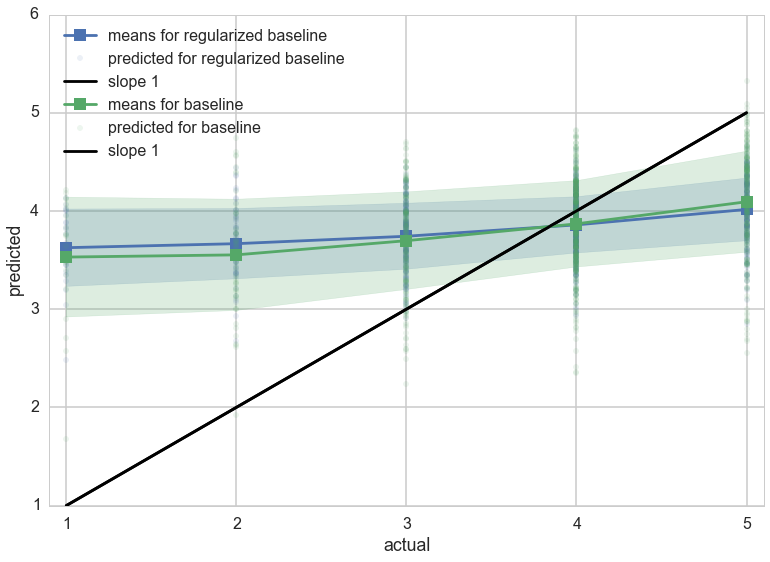

In [101]:
#your code here
#predicting test data
designq_test, test_rats = design_q(testdf,L,finalqs)
#saving test data
predictions['svd'] = regrq.predict(designq_test)
#predicting validate data
designq_validate, validate_rats = design_q(validatedf,L,finalqs)
#saving rankings
predictions_valid['svd'] = regrq.predict(designq_validate)

ax=compare_results(test_rats,predictions['svd'], model="regularized baseline", predicteds=True)
compare_results(testdf.stars,predictions['baseline'], model="baseline", predicteds=True,axis=ax[0])

*your comment here*

We plot the rate at which our regressions converge, seeing that we could perhaps have gotten away with a less stringent convergence criterion.

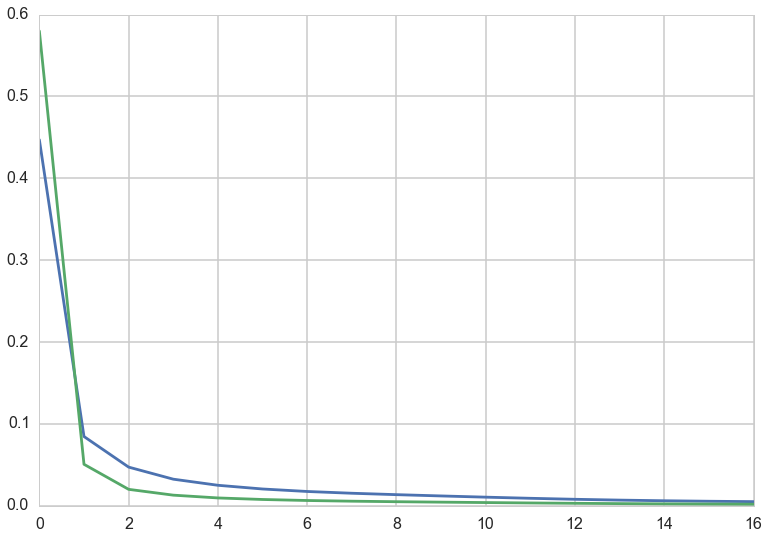

In [102]:
plt.plot(convdict[alphamin][1])

##Q5 Combining results into an ensemble

From the Netflix Progress Prize 2007 paper (see http://brettb.net/project/papers/2007%20The%20BellKor%20solution%20to%20the%20Netflix%20prize.pdf):

>Predictive accuracy is substantially improved when blending multiple predictors. Our experience is that most efforts should be concentrated in deriving substantially different approaches, rather than refining a single technique. Consequently, our solution is an ensemble of many methods.
We approach blending as a linear regression problem. We ought to regress a target ratings vector on multiple predictors. The target rating vector can be the true ratings of the Probe set, and the predictors are the respective estimates for the Probe set by an ensemble of methods. The solution is the coefficients, or the weights, that should be given to each of the predictors in the ensemble.


Finally, we shall combine the ratings obtained from the kNN and the ALS approaches.

###Adding a regularized baseline to kNN

To do a really good job with this one ought to have fit the knn with coefficients from scratch. But we will use a regularized baseline for the kNN instead here, and combine the two and see what we get. 

Furthermore we should have a larger validation set to this combination, as we will combine model predictions on the validation set. This is not true here either. Thus this part of the homework serves more as illustration, and more precisely as an illustration of a new ensembling technique, **stacked** regression.

We'll approach this combination in a simple way, by carrying out a **stacked** linear regress on the *predictions* of the two models. We'll do this regression on the validation set predictions, and check our predictions on the test set.

So we'll add one more model here, `knn_r`, which adds knn on the validation and test sets onto a baseline that is created from the regularized regression `baseline_r`.

#### 5.1 Find the best fit `knn_r model` on the validation set and test sets

Analogous to what you did in 2.5 and 2.6, find the best fit model when the baseline you choose is that from the regularized regression from question 3. Hint: Use `train_fits` for the base line instead of `train_avg` in `get_ratings_user_nbd`).

In [103]:
#your code here
rmsedict2={}
#iterate through k and reg to find min k-reg pair
for k in range(27,31,1):
    for reg in range(100,104,1):
        pt, at = get_ratings_user_nbd(validatedf, traindf, train_fits, db, k=k, reg=reg)
        rmse=get_rmse(at, pt)
        rmsedict2[(k,reg)]=rmse

We find the minimum.

In [104]:
mintup2=min(rmsedict2, key=rmsedict2.get)
mintup2

(29, 102)

In [105]:
predictions['knn_r'], atest = get_ratings_user_nbd(testdf, traindf, train_fits, db, k=mintup2[0], reg=mintup2[1])
predictions_valid['knn_r'], avals = get_ratings_user_nbd(validatedf, traindf, train_fits, db, k=mintup2[0], reg=mintup2[1])

What models have we collected so far?

In [106]:
predictions.keys()

['knn', 'baseline_r', 'svd', 'baseline', 'knn_r']

We construct a dataframe with the two predictions and the actual value on the **Validation** set.

In [107]:
dfensemble=pd.DataFrame.from_dict({'knn_r':predictions_valid['knn_r'],
                                   'svd':predictions_valid['svd'], 
                                   'baseline_r':predictions_valid['baseline_r'], 'y':validatedf.stars.values})

#### 5.2 Carry out an unregularized linear regression of the actual values against the three predictions

Use the `y` values obtained from the validation set in the dataframe `dfensemble`. Regress against the other columns from the validation set. Such a regression is called 'stacking'. Store the regression model in the variable `valreg`

In [108]:
#your code here
import statsmodels.formula.api as smf

#create a regressing ols model
valreg = smf.ols('y ~ knn_r + svd + baseline_r',data=dfensemble).fit()

print valreg.summary()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     85.93
Date:                Fri, 06 Nov 2015   Prob (F-statistic):           4.38e-51
Time:                        13:52:22   Log-Likelihood:                -1889.6
No. Observations:                1422   AIC:                             3787.
Df Residuals:                    1418   BIC:                             3808.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -0.6364      0.310     -2.054      0.0

#### 5.3 Get the same models on the test set and use linear regression to calculate the predictions. Comment

 Store the predictions on the test set in the dataframe `dfensembletest` which should have columns exactly analogous to those on `dfensemble`. Use this dataframe in the prediction process on the test set. Store in the variable `epreds` the predictions of our stacked regression `valreg`, and the actual values of the ratings from the test set in the variable `testactual`. Comment on the results, using the diagram we plot below and the value of the RMSE as compared to before.

In [109]:
#your code here
dfensembletest = pd.DataFrame.from_dict({'knn_r':predictions['knn_r'],
                                   'svd':predictions['svd'], 
                                   'baseline_r':predictions['baseline_r'], 'y':testdf.stars.values})
#predicting on test data
epreds = valreg.predict(dfensembletest)
testactual = dfensembletest.y

Lets plot the results and see the RMSE:

RMSE for ensemble 0.902887850009


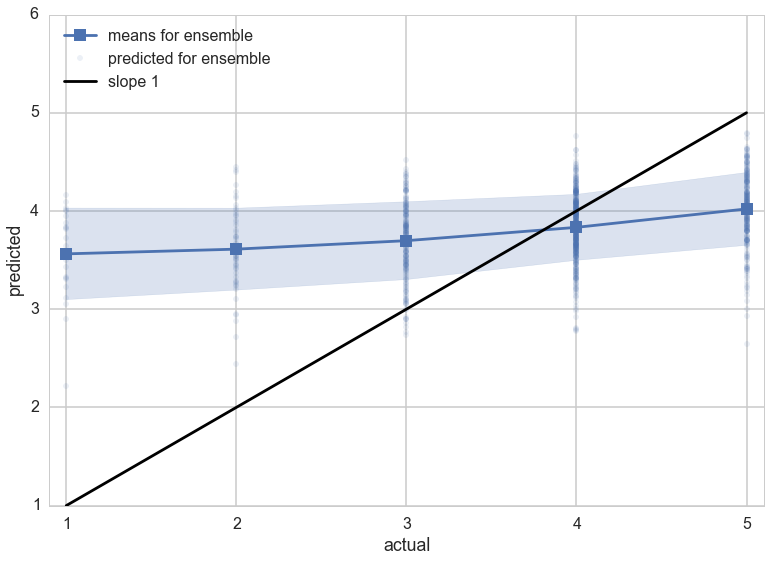

In [110]:
ax=compare_results(testactual, epreds, model="ensemble", predicteds=True);

*your answer here*

See http://web.stanford.edu/~lmackey/papers/netflix_story-nas11-slides.pdf for a fun presentation on Ensembling and the Netflix Prize. If you'd like to learn more, please read Chris Volinksy's papers on the Netflix prize. There are also comprehensive reviews [here](http://arxiv.org/abs/1202.1112) and [here](http://www.grouplens.org/system/files/FnT%20CF%20Recsys%20Survey.pdf).

FIN